# Modules

In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, date, time
import seaborn as sns
from scipy import stats
import scipy.stats as st
import glob
import warnings
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
#from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm  
from scipy.stats import pearsonr
from src.utils.data_utils import advanced_linear_regression
from src.utils.data_utils import assign_experience_level
from src.utils.data_utils import clean_location_column
from scipy.stats import f_oneway

In [2]:
# Suppress certain warnings
warnings.filterwarnings("ignore")

# Dataset

The dataset used in this analysis consists of beer reviews from two beer rating websites,**BeerAdvocate** and **RateBeer**, for a period ranging from 2001 to 2017. For each website, we have 5 files:
- users.csv: metadata about reviewers
- beers.csv : metadata about reviewed beers
- breweries.csv : metadata about breweries
- ratings.txt : all reviews given by users, including numerical ratings and sometimes textual reviews
- reviews.txt : only reviews given by users that include both numerical ratings and textual reviews

In our analysis, we will not use textual reviews. Thus, we will only use ratings.txt files and not reviews.txt files, as we will use all reviews, whether or not they include textual reviews.

### Load data into Dataframes

The .csv files are not too large and can efficiently be loaded into DataFrames.

In [3]:
BA_DATA_FOLDER = 'data/BeerAdvocate/'
RB_DATA_FOLDER = 'data/RateBeer/'

BA_USERS = BA_DATA_FOLDER+"users.csv"
BA_BEERS = BA_DATA_FOLDER+"beers.csv"
BA_BREWERIES = BA_DATA_FOLDER+"breweries.csv"

RB_USERS = RB_DATA_FOLDER+"users.csv"
RB_BEERS = RB_DATA_FOLDER+"beers.csv"
RB_BREWERIES = RB_DATA_FOLDER+"breweries.csv"

In [4]:
ba_users = pd.read_csv(BA_USERS)
ba_beers = pd.read_csv(BA_BEERS)
ba_breweries = pd.read_csv(BA_BREWERIES)

rb_users = pd.read_csv(RB_USERS)
rb_beers = pd.read_csv(RB_BEERS)
rb_breweries = pd.read_csv(RB_BREWERIES)

On the other hand, the ratings.txt files are extremely large, and trying to load them directly into DataFrames leads to kernel freezes. In order to circumvent this problem, we wrote a script (review_parser.py, located in src/scripts), which processes each rating file by dividing it into parts, parsing each part, and saving as JSON. In the notebook, we then load the different JSON files into DataFrames, that we concatenate. Dividing the large .txt files into smaller JSON chunks and then loading each chunk separately, avoids trying to load the entire file into memory at once, which can cause kernel freezes due to memory overload. In addition, JSON is a format that pandas can read efficiently.

In [8]:
# Load BeerAdvocate ratings stored in json files into a single DataFrame
ba_json_files = glob.glob(BA_DATA_FOLDER+'*.json')
ba_df_list = [pd.read_json(file) for file in ba_json_files]
ba_ratings = pd.concat(ba_df_list, ignore_index=True)
ba_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00


In [9]:
# Load RateBeer ratings stored in json files into a single DataFrame
rb_json_files = glob.glob(RB_DATA_FOLDER+'*.json')
rb_df_list = [pd.read_json(file) for file in rb_json_files]
rb_ratings = pd.concat(rb_df_list, ignore_index=True)
rb_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852.0,2.0,4.0,2.0,4.0,8.0,2.0
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761.0,2.0,3.0,2.0,4.0,8.0,1.9
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889.0,3.0,3.0,2.0,3.0,5.0,1.6
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510.0,4.0,3.0,1.0,2.0,5.0,1.5
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778.0,2.0,4.0,2.0,4.0,7.0,1.9


### First look at the data

We will now examine the different DataFrames in more detail.

**BeerAdvocate beer Dataframe**

In [12]:
ba_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
83821,97819,Vietnamese Nut Brown Ale,396,AleSmith Brewing Company,American Brown Ale,10,3,4.75,88.0,NaN,NaN,4.571000,NaN,0,NaN
215415,151312,Brewers Series No. 1 - American Sour Aged In O...,413,Grand Teton Brewing Co.,American Wild Ale,51,9,4.34,91.0,NaN,8.5,4.293333,NaN,0,NaN
62887,49560,Smörpundet Lagrad Årgångsporter,3476,Nynäshamns Ångbryggeri,English Porter,8,7,3.91,NaN,NaN,6.0,3.950000,NaN,0,NaN
17535,120973,La Weiss,11620,Microbrasserie Archibald,Berliner Weissbier,2,0,3.38,NaN,NaN,4.9,3.375000,NaN,0,NaN


Let us explain the different columns of the BeerAdvocate beer Dataframe, in which each row is a beer:
- beer_id, beer_name, brewery_id, brewery_name, style are explicit
- nbr_ratings: total number of reviews for that beer, whether or not they include textual reviews
- nbr_reviews: number of reviews for that beer that include textual reviews
- avg: average rating (out of 5) given to the beer based on user ratings
- ba_score: the BeerAdvocate score assigned to the beer, which corresponds to the beer's overall rating within its style category, calculated using a trimmed mean and a custom Bayesian formula that adjusts for the beer's style, balancing the score based on the number of ratings and the style's average
- bros_score: beer rating given by the site’s founders
- abv: 'Alcohol by volume', which indicates the percentage of alcohol content in the beer
- avg_computed: average rating (out of 5) recalculated using a weighted sum of the different aspect ratings
- zscore: z-score of the beer's average rating, which is a statistical measure that indicates how many standard deviations the average rating is from the mean of all ratings from the BeerAdvocate dataset
- nbr_matched_valid_ratings: number of valid ratings for beers that were successfully matched between two BeerAdvocate and RateBeer
- avg_matched_valid_ratings: average rating of those matched and valid ratings across the sites

The last two columns are related to the analysis performed by Robert West and Gael Lederrey in the following paper: https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf.

**RateBeer beer Dataframe**

In [13]:
rb_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
17163,225793,Arrowhead Raspberry Wheat Ale,15983,Arrowhead Brewing,Fruit Beer,5,NaN,NaN,3.03,4.3,3.200000,NaN,0,NaN
139505,410619,Widawa Imperial Wild Black Kiss Rum BA,14501,Browar Widawa,Imperial Stout,16,55.0,8.0,3.23,8.2,3.306250,NaN,0,NaN
147519,36574,Dahls 1856,1635,Ringnes Bryggeri (Carlsberg),Pale Lager,3,NaN,NaN,2.48,4.5,1.933333,NaN,0,NaN
174944,247940,Lagunitas A Little Sumpin Roggenbier,1167,Lagunitas Brewing Company &#40;Heineken&#41;,Specialty Grain,2,NaN,NaN,3.03,8.0,3.900000,NaN,0,NaN


Let us explain the different columns of the RateBeer beer Dataframe, in which each row is a beer:

The beer_id, beer_name, brewery_id, brewery_name, style, nbr_ratings, avg, abv, avg_computed, z-score, nbr_matched_valid_ratings and avg_matched_valid_ratings are the same as for the BeerAdvocate beer Dataframe.

Some columns are missing compared to the BeerAdvocate beer Dataframe: ba_score and bros_score (which makes sense as these are BeerAdvocate-specific scores), and nbr_reviews.

New columns are present compared to the BeerAdvocate beer Dataframe:
- overall_score: score (out of 100) which "reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer", calculated by considering the ratings given by each user and the total number of ratings for the beer
- style_score: score given to the beer (out of 100) specifically within its style category

**BeerAdvocate user Dataframe**

In [14]:
ba_users.sample(4)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
146780,1,1,jdwayne00.1075820,jdwayne00,1.448968e+09,"United States, Texas"
39032,4,0,aetorres14.873930,aetorres14,1.412590e+09,"United States, Indiana"
69528,6,0,willthemad17.1089123,WillTheMad17,1.451560e+09,"United States, California"
63256,4,2,diverdownrick.154593,diverdownrick,1.187863e+09,"United States, Massachusetts"


Let us explain the different columns of the BeerAdvocate user Dataframe, in which each row is a reviewer:
- nbr_ratings, nbr_reviews, user_id, user_name, and location are explicit
- joined: timestamp indicating when the user joined BeerAdvocate in Unix timestamp format (the number of seconds since January 1, 1970, 00:00:00 UTC)

**RateBeer user Dataframe**

In [15]:
rb_users.sample(4)

,nbr_ratings,user_id,user_name,joined,location
68442,2,28686,tex007,1.129370e+09,Belgium
35134,1,355544,Gunnagard,1.422702e+09,NaN
47912,4,103111,Flinch,1.268305e+09,"United States, Florida"
11817,9,5708,acnemaster99,1.033380e+09,"United States, New York"


Let us explain the different columns of the RateBeer user Dataframe, in which each row is a reviewer:

The columns are the same as in the BeerAdvocate user Dataframe (joined is obviously the timestamp indicating when the user joined RateBeer and not BeerAdvocate), except that nbr_reviews is missing.

**Brewery Dataframes**

In [16]:
ba_breweries.sample(4)

,id,location,name,nbr_beers
15123,2520,France,Brasserie Lancelot,20
13460,31704,"United States, Oregon",Agrarian Ales,117
5453,29104,Australia,Sweetwater Brewery,5
1938,42690,Canada,Provincial Brand Ltd,1


In [17]:
rb_breweries.sample(4)

,id,location,name,nbr_beers
16136,5906,"United States, Pennsylvania",Iron Hill Media,48
22275,27816,England,Nisa Retail Ltd.,2
18765,5691,"United States, Michigan",Fort Street Brewery,178
13183,25213,"United States, Wisconsin",Lions Tail Brewing Company,19


The columns are explicit and are the same for the 2 websites. Each row is a brewery.

**Rating Dataframes**

In [18]:
ba_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
1186756,Boatswain Chocolate Stout,75507.0,Rhinelander Brewing Company,27642.0,American Stout,5.4,2017-03-07 11:00:00,godawgs,godawgs.852869,4.0,3.5,3.0,3.25,3.25,3.33
8259155,St. Louis Gueuze Fond Tradition,5212.0,Brouwerij Van Honsebrouck N.V.,212.0,Gueuze,5.0,2013-12-17 11:00:00,TickleMeTony,ticklemetony.754624,NaN,NaN,NaN,NaN,NaN,4.00
7520835,312 Urban Wheat,17141.0,Goose Island Beer Co.,1146.0,American Pale Wheat Ale,4.2,2008-03-14 11:00:00,champ103,champ103.156510,3.5,2.0,2.0,2.00,3.00,2.29
7195544,Black Butte XXIV,83624.0,Deschutes Brewery,63.0,American Porter,11.0,2014-03-30 10:00:00,Invictus,invictus.728725,NaN,NaN,NaN,NaN,NaN,3.75


In [19]:
rb_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
5106137,Odd Side Ales King Of Tarts,386675.0,Odd Side Ales,11793.0,Sour/Wild Ale,6.0,2016-03-05 11:00:00,SpongeRuiner,281995.0,3.0,7.0,3.0,7.0,20.0,4.0
5967313,Marstons Owd Rodger,11211.0,Marstons,56.0,English Strong Ale,7.4,2010-12-08 11:00:00,Archibaldo de la Cruz,78396.0,3.0,6.0,3.0,6.0,13.0,3.1
3516604,Jacks Abby Saxony Lager,485145.0,Jacks Abby Brewing,13049.0,Zwickel/Keller/Landbier,5.0,2017-04-13 10:00:00,malrubius,50823.0,4.0,7.0,4.0,8.0,15.0,3.8
155362,La Succursale Miláček,193928.0,La Succursale,12864.0,Czech Pilsner (Světlý),5.0,2012-12-15 11:00:00,JulienHuxley,79809.0,3.0,7.0,4.0,8.0,16.0,3.8


The columns are the same for the 2 Dataframes. Each row corresponds to an individual review. Most column names are explicit. 
- 'appearance','aroma', 'palate','taste' correspond to aspect ratings (out of 5)
- 'overall' is the mean of the 4 aspect ratings
- 'rating' is the final rating given by the user to the beer

# 0) Data cleaning

### **BASIC CLEANING**

## Filtering Dataframes

Let us start by removing columns in the different Dataframes that we will not use in our analysis.

The following rows will not be used in our analysis:
nbr_reviews, ba_score, bros_score, abv, avg_computed, zscore, nbr_matched_valid_ratings and avg_matched_valid_ratings, overall_score and style_score.

Let us remove them.

In [20]:
useless_columns_ba = ['nbr_reviews', 'ba_score', 'bros_score', 'abv', 'avg_computed', 'zscore', 'nbr_matched_valid_ratings', 'avg_matched_valid_ratings']
ba_beers = ba_beers.drop(columns=useless_columns_ba)
print(ba_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


In [21]:
useless_columns_rb = [col for col in useless_columns_ba if col not in ['nbr_reviews','ba_score', 'bros_score']] + ['overall_score', 'style_score']
rb_beers = rb_beers.drop(columns=useless_columns_rb)
print(rb_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


We will also not use the timestamps indicating the time when users joined the platforms, so let us remove this as well.

In [22]:
ba_users = ba_users.drop(columns='joined')
rb_users = rb_users.drop(columns='joined')
print(ba_users.columns)

Index(['nbr_ratings', 'nbr_reviews', 'user_id', 'user_name', 'location'], dtype='object')


## Verifying value types

Let us verify that the values in the different columns of the different Dataframes have the appropriate type.

In [23]:
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [24]:
print(ba_users.dtypes,'\n','\n',rb_users.dtypes)

nbr_ratings     int64
nbr_reviews     int64
user_id        object
user_name      object
location       object
dtype: object 
 
 nbr_ratings     int64
user_id         int64
user_name      object
location       object
dtype: object


In [25]:
print(ba_breweries.dtypes,'\n','\n',rb_breweries.dtypes)

id            int64
location     object
name         object
nbr_beers     int64
dtype: object 
 
 id            int64
location     object
name         object
nbr_beers     int64
dtype: object


In [26]:
columns_to_convert = ['beer_name', 'brewery_name', 'style']

ba_beers[columns_to_convert] = ba_beers[columns_to_convert].apply(lambda col: col.astype(str))
rb_beers[columns_to_convert] = rb_beers[columns_to_convert].apply(lambda col: col.astype(str))
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [27]:
print(ba_ratings.dtypes,'\n','\n',rb_ratings.dtypes)

beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                 object
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object 
 
 beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                float64
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object


The types of the values in the different columns of the different Dataframes seem appropriate.

## Dealing with missing values

*Beers with no reviews*

Let us verify that all the beers in the beer DataFrames have at least received 1 review.

In [28]:
# get the number of beers with 0 reviews
# Beer Advocate
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)

# Rate Beer
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 32841
Number of beers with no reviews (Rate Beer): 45391


We can see that in Both Dataframes, there are many beers with no reviews. These beers are useless for our analysis and we can remove them from the DataFrames.

In [29]:
# remove beers with zero reviews
# Beer Advocate
ba_beers = ba_beers[ba_beers['nbr_ratings'] != 0]
# Rate Beer
rb_beers = rb_beers[rb_beers['nbr_ratings'] != 0]

# verification:
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 0
Number of beers with no reviews (Rate Beer): 0


*Reviews with no final rating*

Let us now determine if some reviews lack a final rating. If that is the case, we will remove them from the rating DataFrames as we will need final ratings in our analysis. The final rating, unlike the overall rating, cannot be calculated using aspect ratings, so we cannot retrieve missing final rating values. Some reviews may lack certain aspect ratings, but we will not remove them as if they do have a final rating, we will be able to use them in many parts of our analysis.

In [30]:
# get the number of reviews with Nan in the 'rating' column
# Beer Advocate
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
# Rate Beer
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 2
Number of reviews lacking a final rating (Rate Beer): 2


There are only 2 reviews lacking a final rating for each website, but let us remove them anyway.

In [31]:
# remove reviews with no final rating
ba_ratings = ba_ratings.dropna(subset=['rating'])
rb_ratings = rb_ratings.dropna(subset=['rating'])

# verification 
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 0
Number of reviews lacking a final rating (Rate Beer): 0


## Cleaning location information

Let us have a closer look at the values present in the 'location' column of user and brewery DataFrames.

In [32]:
ba_users['location'].value_counts()

location
United States, California       11638
United States, Pennsylvania      8689
United States, New York          7432
United States, Illinois          6866
United States, Massachusetts     6658
                                ...  
Angola                              1
Kazakhstan                          1
Tokelau                             1
Sri Lanka                           1
Sint Maarten                        1
Name: count, Length: 194, dtype: int64

In [33]:
rb_users['location'].value_counts()

location
Canada                         3255
United States, California      2804
England                        2734
Poland                         1701
United States, Pennsylvania    1632
                               ... 
Liechtenstein                     1
Lesotho                           1
East Timor                        1
Falkland Islands                  1
Tibet                             1
Name: count, Length: 222, dtype: int64

In [34]:
ba_breweries['location'].value_counts()

location
Germany                                                                                                                                                                          1431
England                                                                                                                                                                           997
United States, California                                                                                                                                                         929
Canada                                                                                                                                                                            775
United States, Washington                                                                                                                                                         411
                                                                                 

In [35]:
rb_breweries['location'].value_counts()

location
England                      2124
Germany                      1999
Italy                        1051
Canada                        884
United States, California     867
                             ... 
Senegal                         1
Mozambique                      1
French Polynesia                1
Papua New Guinea                1
Gabon                           1
Name: count, Length: 267, dtype: int64

We can make 2 important observations: US locations all contain state information, and some locations contain embedded HTML links. We will remove both these HTML links and the state information, as we will not use it in our analysis. We will do so by applying a function named 'clean_location_column' which cleans the location information and that we have written in src/utils/data_utils.py().

In [36]:
# Clean location information in user and brewery dataframes
# Beer Advocate
ba_users = clean_location_column (ba_users)
ba_breweries = clean_location_column (ba_breweries)

# Rate Beer
rb_users = clean_location_column (rb_users)
rb_breweries = clean_location_column (rb_breweries)

Let us now have a look at the cleaned location columns.

In [37]:
ba_users['location'].value_counts()

location
United States                               113223
nan                                          31279
Canada                                        3324
England                                        791
Australia                                      520
                                             ...  
South Georgia and South Sandwich Islands         1
Angola                                           1
Kazakhstan                                       1
Egypt                                            1
Sint Maarten                                     1
Name: count, Length: 146, dtype: int64

In [38]:
rb_users['location'].value_counts()

location
United States       26855
nan                 19582
Canada               3255
England              2734
Poland               1701
                    ...  
Honduras                1
Falkland Islands        1
Kyrgyzstan              1
Papua New Guinea        1
Tibet                   1
Name: count, Length: 174, dtype: int64

In [39]:
ba_breweries['location'].value_counts()

location
United States            7399
Germany                  1431
England                   997
Canada                    775
France                    402
                         ... 
Equatorial Guinea           1
Tajikistan                  1
Palau                       1
French Guiana               1
Sao Tome and Principe       1
Name: count, Length: 212, dtype: int64

In [40]:
rb_breweries['location'].value_counts()

location
United States            6921
England                  2124
Germany                  1999
Italy                    1051
Canada                    884
                         ... 
Sao Tome and Principe       1
Iraq                        1
Micronesia                  1
French Guiana               1
Gabon                       1
Name: count, Length: 217, dtype: int64

### **'LOCATION-SPECIFIC' CLEANING**

Several parts of our analysis will involve comparing data from different countries and will require working with the location information in the user DataFrames. In these parts, we will only consider countries with a 'sufficiently large' number of reviewers, as only a few reviewers may not be representative of an entire country. We will thus filter out countries that we consider to have not enough reviewers. We decide arbitrarily to filter out countries with less than 10 different reviewers.

In this part of the data cleaning, we will work on a copy of the original DataFrames, and we will use these copies only for the parts of the analysis where we compare certain countries. Indeed, this filtering is not relevant for the parts that do not involve comparing certain countries.

In [41]:
# create copies of the user and rating DataFrames, which will undergo filtering related to the location information
ba_users_loc_filtered = ba_users.copy()
rb_users_loc_filtered = rb_users.copy()
ba_ratings_loc_filtered = ba_ratings.copy()
rb_ratings_loc_filtered = rb_ratings.copy()

## Removing users with missing location information

First, let us determine if some users are missing the location information.

In [42]:
# get the number of users with 'nan' in the 'location' column
# Beer Advocate
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
# Rate Beer
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 31279
Number of users lacking the location information (Rate Beer): 19582


We can see that there are indeed some users missing the location information. Let us remove these users.

In [43]:
# remove users with 'nan' in the 'location' column
ba_users_loc_filtered = ba_users_loc_filtered[ba_users_loc_filtered['location'] != 'nan']
rb_users_loc_filtered = rb_users_loc_filtered[rb_users_loc_filtered['location'] != 'nan']

# verification
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 0
Number of users lacking the location information (Rate Beer): 0


## Filtering out users and reviews written by users from countries with too few users

Let us first identify the countries with a number of users that is smaller than the threshold we set earlier, that is, 10 users.

In [44]:
# concatenate the 'location' columns from the 2 user dataframes
combined_locations = pd.concat([ba_users_loc_filtered['location'], rb_users_loc_filtered['location']])

# get the counts of each unique value in 'location'
location_counts = combined_locations.value_counts()

# keep only locations with less than 10 counts
locations_with_few_counts = location_counts[location_counts < 50]

# Get the list of location values with less than 10 counts
countries_with_few_users = locations_with_few_counts.index.tolist()

print("Countries with less than 10 users across both DataFrames:")
print(countries_with_few_users)

Countries with less than 10 users across both DataFrames:
['Aotearoa', 'Panama', 'Colombia', 'Bosnia and Herzegovina', 'Costa Rica', 'Cyprus', 'Luxembourg', 'Belarus', 'Dominican Republic', 'El Salvador', 'Peru', 'Moldova', 'Guatemala', 'Ecuador', 'Macedonia', 'Venezuela', 'Paraguay', 'Uruguay', 'Lebanon', 'Malaysia', 'Vietnam', 'Indonesia', 'Virgin Islands (U.S.)', 'Bahamas', 'Faroe Islands', 'Afghanistan', 'Malta', 'Andorra', 'Cambodia', 'Guam', 'Kenya', 'United Arab Emirates', 'Isle of Man', 'Antarctica', 'Cayman Islands', 'Bermuda', 'Bolivia', 'Honduras', 'Montenegro', 'Egypt', 'Tanzania', 'Uganda', 'Botswana', 'Zimbabwe', 'Albania', 'Tajikistan', 'Azerbaijan', 'Trinidad and Tobago', 'American Samoa', 'Tunisia', 'Jersey', 'Vanuatu', 'Pakistan', 'Jordan', 'Mauritius', 'Belize', 'Nicaragua', 'Barbados', 'Mozambique', 'Aruba', 'Uzbekistan', 'Nigeria', 'Palestine', 'Namibia', 'Abkhazia', 'Papua New Guinea', 'Armenia', 'Morocco', 'Nepal', 'Burkina Faso', 'Marshall Islands', 'Ascension I

Let us determine if filtering out these 113 countries would leave us with enough data, ie with enough countries, to perform our analysis comparing different countries.

In [45]:
print('Remaining countries after filtering:',(len(location_counts)-len(locations_with_few_counts)))

Remaining countries after filtering: 55


Filtering out those countries would leave us with 88 countries, which is enough to perform our analysis.

Ultimately, we would like to remove reviews from users coming from countries with too few reviewers. 
To do so, we will start by adding the user location information to review DataFrames. This will facilitate the filtering and analysis.

In [46]:
# merge rating dataframes with user dataframes on 'user_id' to add the'location' column to rating dataframes as 'user_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'user_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'user_location'})

ba_ratings_loc_filtered.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland


We now must remove the reviews from users whose location is NaN. Such users correspond to the users lacking a ocation information that have been previously removed from the user dataframes, but which are still present in the review dataframes.

In [47]:
# remove reviews from users for which the location is NaN
ba_ratings_loc_filtered = ba_ratings_loc_filtered.dropna(subset=['user_location'])
rb_ratings_loc_filtered = rb_ratings_loc_filtered.dropna(subset=['user_location'])

We can now remove reviews from users coming from countries with too few reviewers.

In [48]:
# remove reviews where 'user_location' is in the 'countries_with_few_users' list
ba_ratings_loc_filtered = ba_ratings_loc_filtered[~ba_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]
rb_ratings_loc_filtered = rb_ratings_loc_filtered[~rb_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]

We will now remove users coming from countries with too few reviewers from the user dataframes.

In [49]:
# remove users for which 'location' is in the 'countries_with_few_users' list
ba_users_loc_filtered = ba_users_loc_filtered[~ba_users_loc_filtered['location'].isin(countries_with_few_users)]
rb_users_loc_filtered = rb_users_loc_filtered[~rb_users_loc_filtered['location'].isin(countries_with_few_users)]

In [79]:
ba_users_loc_filtered.head()

,nbr_ratings,nbr_reviews,user_id,user_name,location
0,7820,465,nmann08.184925,nmann08,United States
1,2521,2504,stjamesgate.163714,StJamesGate,United States
2,1797,1143,mdagnew.19527,mdagnew,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,Northern Ireland


In [80]:
rb_users_loc_filtered.head()

,nbr_ratings,user_id,user_name,location
0,1890,175852,Manslow,Poland
1,89,442761,MAGICuenca91,Spain
2,169,288889,Sibarh,Poland
3,3371,250510,fombe89,Spain
4,13043,122778,kevnic2008,Germany


## Adding brewery location information to filtered review DataFrames

Finally, to facilitate our analysis, we will add the brewery location information for each beer reviewed in the review dataframes. 

In [50]:
ba_breweries_loc_filtered = ba_breweries.copy()
rb_breweries_loc_filtered = rb_breweries.copy()

In [51]:
# rename 'id' column to 'brewerie_id' column in brewery dataframes to facilitate merging with rating dataframes
ba_breweries_loc_filtered = ba_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})
rb_breweries_loc_filtered = rb_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})

# merge rating dataframes with brewery dataframes on 'brewery_id' to add the'location' column to rating dataframes as 'brewerie_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

ba_ratings_loc_filtered.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States,Gabon
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States,Northern Ireland
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland,Northern Ireland


In [78]:
rb_breweries_loc_filtered.head()

,brewery_id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


# 1) Link between culture and taste

## a) Beer style preferences

In [48]:
# use clustering techniques to determine beer style is most popular in each country / geographic area
# use time information to determine if regional beer style preferences are stable (which would suggest that they are 
# strongly affected by culture)or if they vary over time

## b) Importance of specific beer attributes

In [49]:
attributes = ['appearance', 'aroma', 'palate', 'taste'] 
ba_ratings_loc_filtered_no_missing= ba_ratings_loc_filtered.dropna(subset= attributes )
rb_ratings_loc_filtered_no_missing = rb_ratings_loc_filtered.dropna(subset= attributes )
display(rb_ratings_loc_filtered_no_missing)
display(ba_ratings_loc_filtered_no_missing)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852.0,2.0,4.0,2.0,4.0,8.0,2.0,Poland,Gabon
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761.0,2.0,3.0,2.0,4.0,8.0,1.9,Spain,Gabon
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889.0,3.0,3.0,2.0,3.0,5.0,1.6,Poland,Gabon
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510.0,4.0,3.0,1.0,2.0,5.0,1.5,Spain,Gabon
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778.0,2.0,4.0,2.0,4.0,7.0,1.9,Germany,Gabon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6862640,Svejk Blonde,220897.0,Svejk Beer Garden,17155.0,Pale Lager,NaN,2014-09-18 10:00:00,Travlr,83882.0,3.0,6.0,2.0,5.0,10.0,2.6,United States,Albania
6862641,Svejk Blonde,220897.0,Svejk Beer Garden,17155.0,Pale Lager,NaN,2013-12-01 11:00:00,TBone,10233.0,2.0,5.0,2.0,6.0,10.0,2.5,Finland,Albania
6862642,Svejk Dark,220898.0,Svejk Beer Garden,17155.0,Dunkel/Tmavý,NaN,2014-11-04 11:00:00,Rob_D_UK,257161.0,3.0,4.0,2.0,5.0,9.0,2.3,Spain,Albania
6862643,Svejk Dark,220898.0,Svejk Beer Garden,17155.0,Dunkel/Tmavý,NaN,2014-09-16 10:00:00,Travlr,83882.0,3.0,5.0,1.0,4.0,6.0,1.9,United States,Albania


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States,Gabon
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States,Northern Ireland
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland,Northern Ireland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7875064,Irvington Pale Ale,19141.0,Summit Station Restaurant & Brewery,885.0,American Pale Ale (APA),6.8,2004-11-15 11:00:00,ecoboy,ecoboy.1641,3.50,3.00,3.50,3.00,3.5,3.18,United States,United States
7875065,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2006-02-27 11:00:00,jaluria,jaluria.31362,3.50,3.50,3.50,4.00,4.0,3.80,United States,United States
7875066,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2006-02-19 11:00:00,Dithyramb,dithyramb.4413,3.00,3.00,3.00,2.50,3.0,2.80,United States,United States
7875067,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2004-08-10 10:00:00,ManekiNeko,manekineko.2654,3.00,1.50,1.00,1.50,1.5,1.54,United States,United States


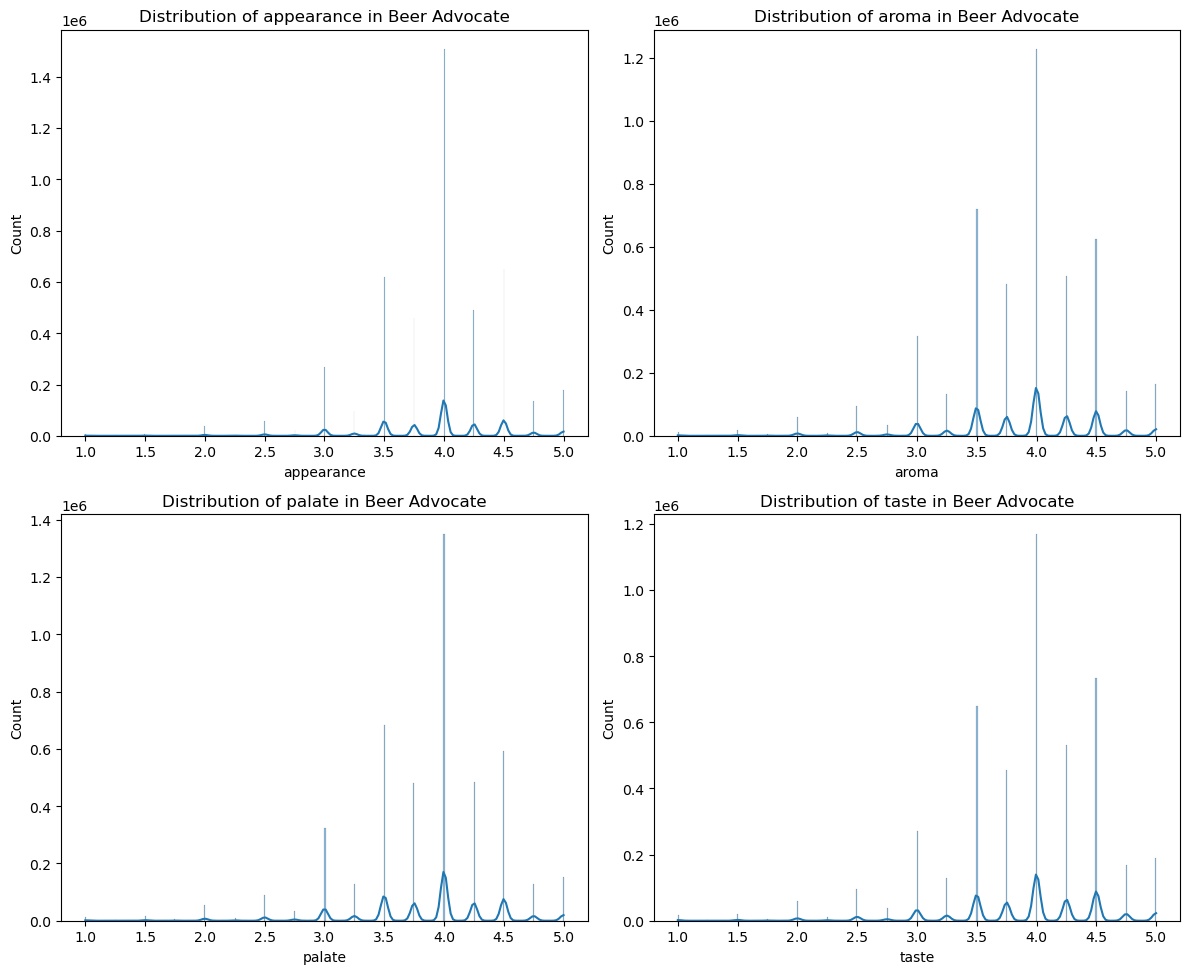

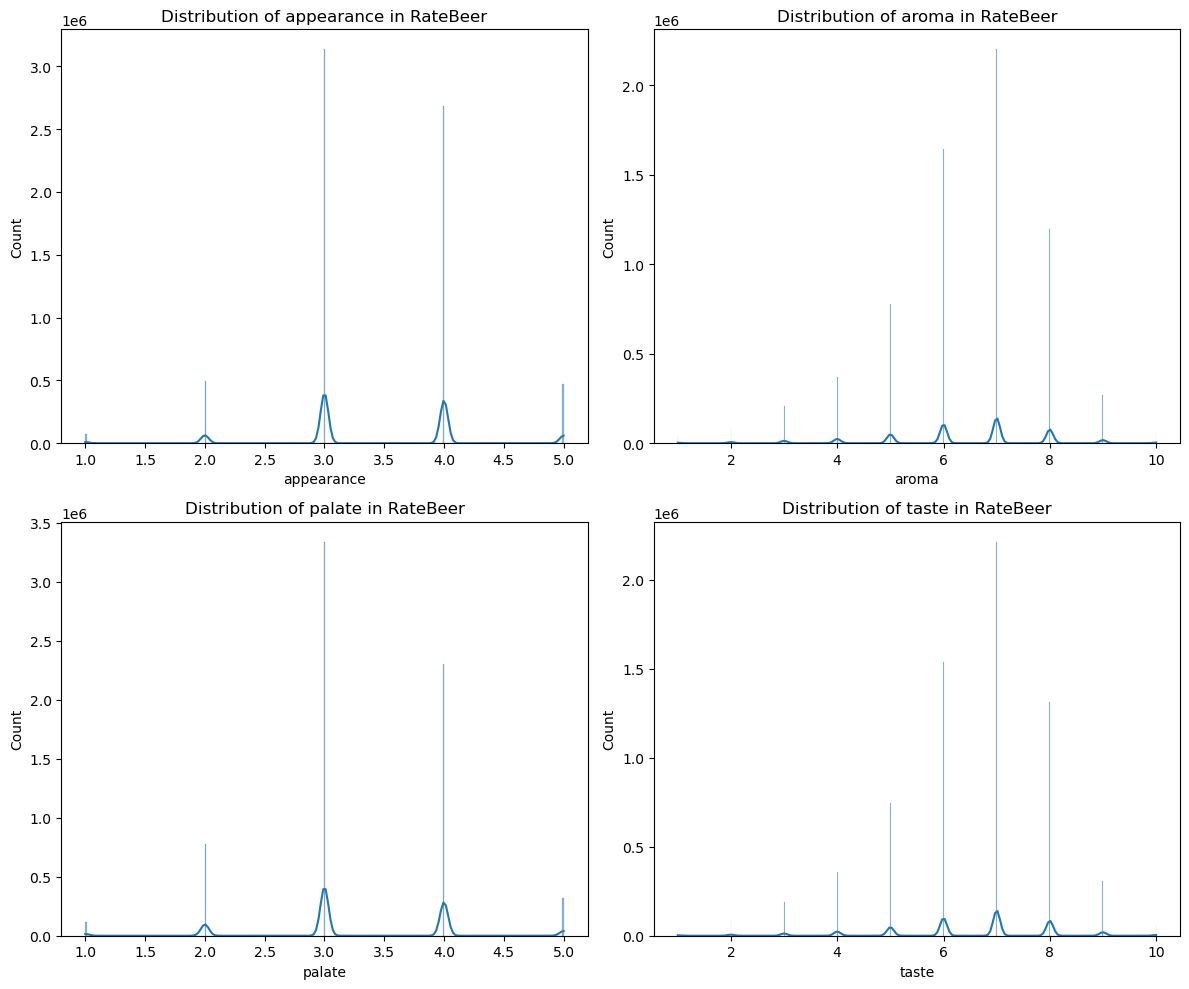

In [51]:
# perform linear regression between attribute ratings the final rating for all countries together and compare coefficients for each attribute
# perform linear regression between attribute ratings the final rating for the different countries separately and observe the distribution of the coefficients for the different attributes across countries


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, col in enumerate(attributes):
    sns.histplot(ba_ratings_loc_filtered_no_missing[col], kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {col} in Beer Advocate")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, col in enumerate(attributes):
    sns.histplot(rb_ratings_loc_filtered_no_missing[col], kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {col} in RateBeer")
plt.tight_layout()
plt.show()

Here we are looking at the general distribution of the beer atributes to get a gist of the ratings to differentiate between each attribute and what are the differences between the databases. Here we can see that the ratings in the Rate Beer are more harsh compared to the Beer Advocate and they are generally lower. Also to note that the taste and aroma ratings are given out of ten in Rate Beer , This can cause to some problems while concanating and doing correlation analysis.

In [52]:
rb_ratings_loc_filtered_no_missing['taste'] = rb_ratings_loc_filtered_no_missing['taste'] / 2
rb_ratings_loc_filtered_no_missing['aroma'] = rb_ratings_loc_filtered_no_missing['aroma'] / 2

Here we scaled the Rate Beer's taste and aroma beer attributes accordingly to the other attributes' rating scale so that we have a common scale. ( 5 point rating scale)

In [53]:
total_ratings_loc_filtered_no_missing = pd.concat([ba_ratings_loc_filtered_no_missing, rb_ratings_loc_filtered_no_missing], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_loc_filtered_no_missing = total_ratings_loc_filtered_no_missing.reset_index(drop=True)
display(total_ratings_loc_filtered_no_missing)

,source,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,ba,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States,Gabon
1,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States,Northern Ireland
2,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland,Northern Ireland
3,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland,Northern Ireland
4,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland,Northern Ireland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11413515,rb,Svejk Blonde,220897.0,Svejk Beer Garden,17155.0,Pale Lager,NaN,2014-09-18 10:00:00,Travlr,83882.0,3.00,3.00,2.00,2.50,10.0,2.60,United States,Albania
11413516,rb,Svejk Blonde,220897.0,Svejk Beer Garden,17155.0,Pale Lager,NaN,2013-12-01 11:00:00,TBone,10233.0,2.00,2.50,2.00,3.00,10.0,2.50,Finland,Albania
11413517,rb,Svejk Dark,220898.0,Svejk Beer Garden,17155.0,Dunkel/Tmavý,NaN,2014-11-04 11:00:00,Rob_D_UK,257161.0,3.00,2.00,2.00,2.50,9.0,2.30,Spain,Albania
11413518,rb,Svejk Dark,220898.0,Svejk Beer Garden,17155.0,Dunkel/Tmavý,NaN,2014-09-16 10:00:00,Travlr,83882.0,3.00,2.50,1.00,2.00,6.0,1.90,United States,Albania


Here we concanated the two data frames together and added a source column so that we are not losing track of the origin of each rating.This data frame will be the main data frame for linear regression analysis as it will give us the total ratings

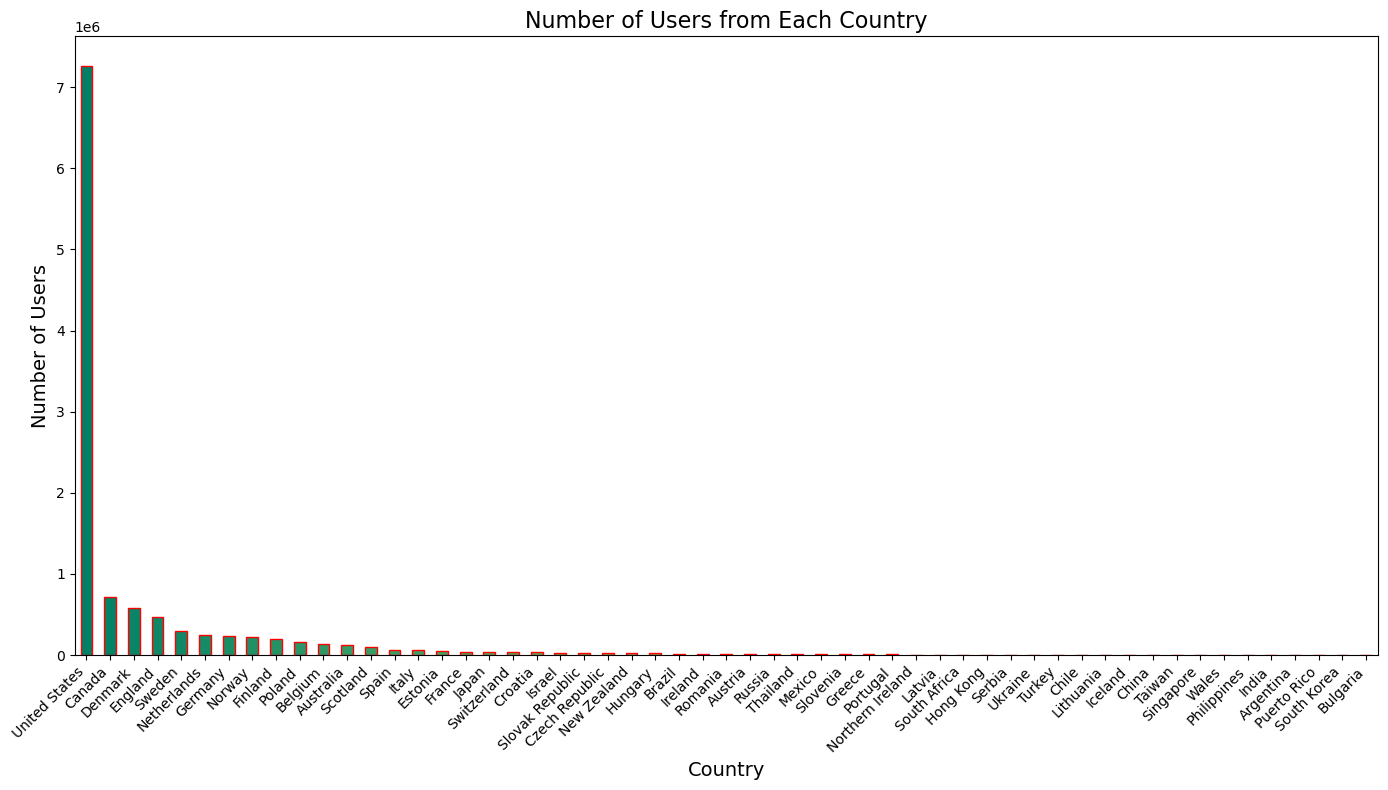

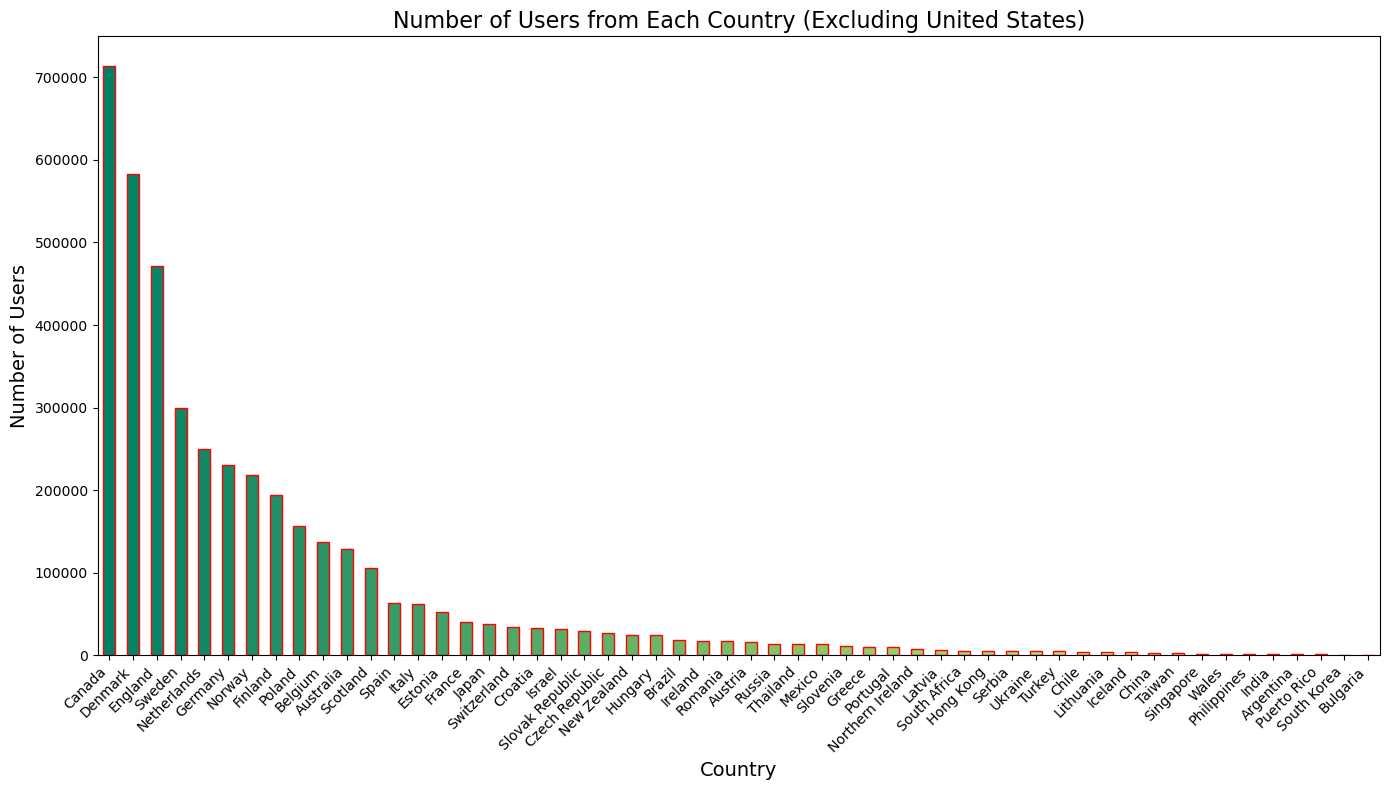

In [56]:
country_counts = total_ratings_loc_filtered_no_missing['user_location'].value_counts()
colors = plt.cm.summer(np.linspace(0, 1, len(country_counts)))
plt.figure(figsize=(14, 8))
country_counts.plot(kind='bar', color=colors, edgecolor='red')
plt.title("Number of Users from Each Country", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  
plt.show()

usa_filtered_ratings = total_ratings_loc_filtered_no_missing[total_ratings_loc_filtered_no_missing['user_location'] != 'United States']

country_counts_without_usa= usa_filtered_ratings['user_location'].value_counts()

colors = plt.cm.summer(np.linspace(0, 1, len(country_counts)))

plt.figure(figsize=(14, 8))
country_counts_without_usa.plot(kind='bar', color=colors, edgecolor='red')
plt.title("Number of Users from Each Country (Excluding United States)", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Here we wanted to see how many users are coming from each country and plotted it by histograms to visualize it. We have two plots of histogram one with United States and one without it.This is because United States has much more user data compared to other countries so the histogram plots becomes a little bit skewed, so to get a better look at other countries contribution we made another plot without USA.

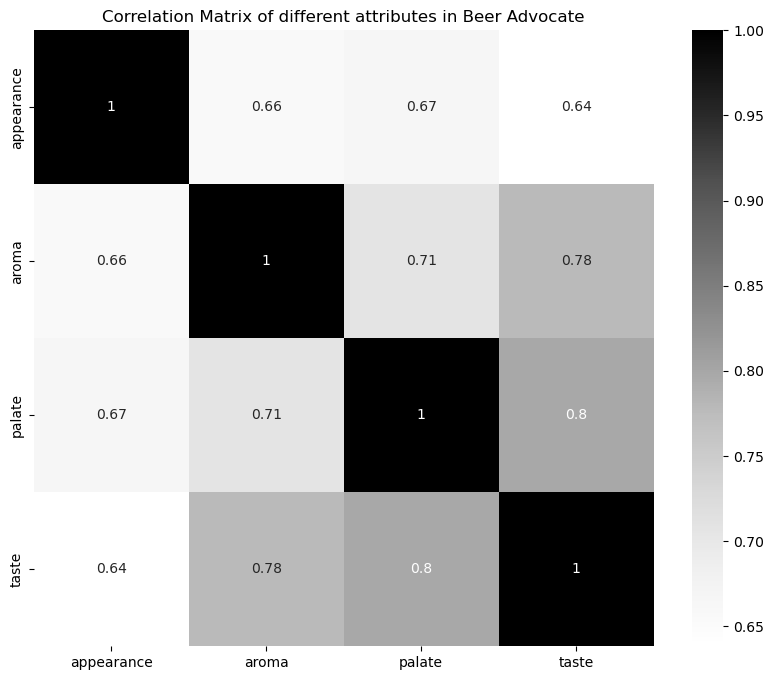

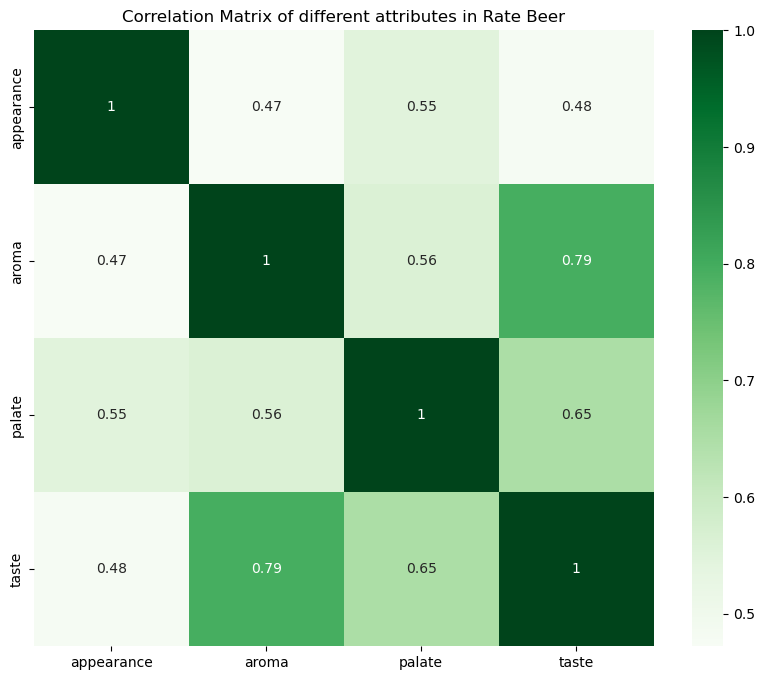

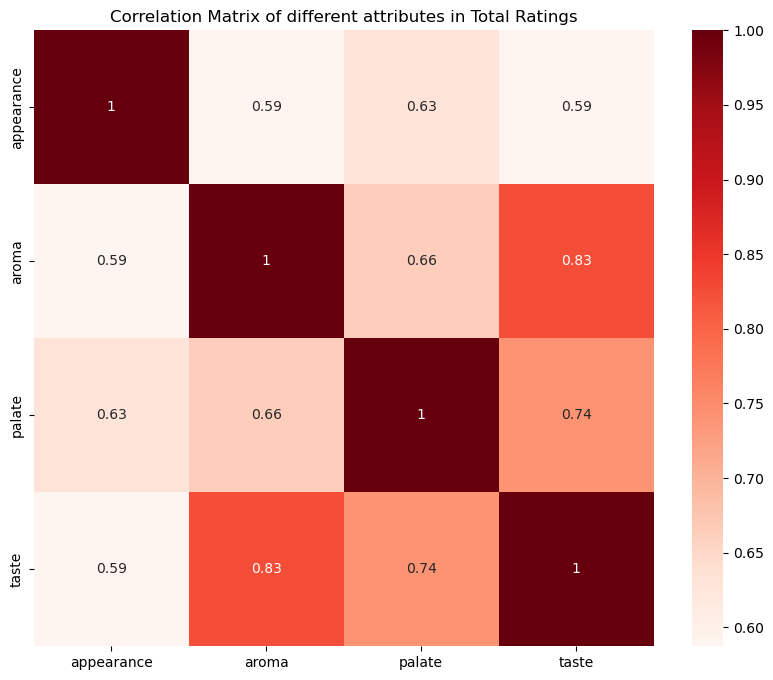

In [57]:
# We will try to see and compare how each attributes correlates between each other 
correlation_matrix_1 = ba_ratings_loc_filtered_no_missing[attributes].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_1, annot=True, cmap="Greys")
plt.title("Correlation Matrix of different attributes in Beer Advocate")

correlation_matrix_2 = rb_ratings_loc_filtered_no_missing[attributes].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_2, annot=True, cmap="Greens")
plt.title("Correlation Matrix of different attributes in Rate Beer")

correlation_matrix_total = total_ratings_loc_filtered_no_missing[attributes].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_total, annot=True, cmap="Reds")
plt.title("Correlation Matrix of different attributes in Total Ratings")
plt.show()
plt.close()

Here we see the correlation matrix of each data frame, including the total ratings which is created by the concatanation of Rate Beer and Beer Advocate data frames. This matrix plot gives us a good information about the correalation between beer attributes and how the ratings differentiate between the data frames. We can see that in the Beer Advocate data frame taste aroma and palate attributes have a high correlation between each other while appearance also correlating to them but not as high. . In the Rate Beer data frame we see that aroma and taste correlates more between each other then with palate.Palate still correlates with them but not as strong as it was in Beer Advocate. The suprising finding here is that in the total ratings data frame, the combination of the two data frames gives us a stronger correlation between aroma and taste, while causing a remarkable drop of correlation of the palate attribute with them.These differences of correlation across each data frame indicate to us that the user profile of the two platforms have a distinct look on the attributes and their contribution to elavate each other.High correlation numbers between the attributes (especially the aroma and taste attributes) can be a sign of multicolineratiy which is important to take into account while doing the linear regression analyses.

In [58]:
beer_latvia = total_ratings_loc_filtered_no_missing[total_ratings_loc_filtered_no_missing['user_location'] == 'Latvia']
display(beer_latvia)

,source,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
14118,ba,Dark Dunter,134565.0,Broughton Ales Ltd,46.0,English Stout,4.8,2015-10-19 10:00:00,audzeejs,audzeejs.975411,3.50,3.50,2.50,2.50,3.00,2.90,Latvia,Scotland
21931,ba,5AM Saint,55191.0,BrewDog,16315.0,American Amber / Red Ale,5.0,2015-04-17 10:00:00,audzeejs,audzeejs.975411,3.75,4.50,3.75,3.75,3.75,3.93,Latvia,Scotland
24999,ba,Dead Pony Club,83463.0,BrewDog,16315.0,American Pale Ale (APA),3.8,2015-04-29 10:00:00,audzeejs,audzeejs.975411,3.50,4.25,4.00,4.00,4.00,4.03,Latvia,Scotland
25627,ba,"Dogma (7,4%)",80281.0,BrewDog,16315.0,Scotch Ale / Wee Heavy,7.4,2015-04-20 10:00:00,audzeejs,audzeejs.975411,4.00,4.50,3.75,4.00,4.00,4.10,Latvia,Scotland
26142,ba,Hardcore IPA,41505.0,BrewDog,16315.0,American Double / Imperial IPA,9.2,2015-05-22 10:00:00,audzeejs,audzeejs.975411,4.00,4.25,3.50,3.75,3.75,3.86,Latvia,Scotland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11411406,rb,Chang Beer,59123.0,Thai Beverages,391.0,Pale Lager,5.0,2014-09-15 10:00:00,adodo,291883.0,2.00,1.00,1.00,1.00,5.00,1.20,Latvia,Thailand
11411489,rb,Chang Beer,59123.0,Thai Beverages,391.0,Pale Lager,5.0,2014-03-16 11:00:00,Alusmamuts,231465.0,3.00,3.00,2.00,1.50,8.00,2.20,Latvia,Thailand
11411534,rb,Chang Beer,59123.0,Thai Beverages,391.0,Pale Lager,5.0,2013-11-02 11:00:00,zenkis,175477.0,2.00,1.00,2.00,1.00,6.00,1.40,Latvia,Thailand
11411536,rb,Chang Beer,59123.0,Thai Beverages,391.0,Pale Lager,5.0,2014-06-12 10:00:00,Vells,221879.0,3.00,2.00,1.00,2.50,10.00,2.30,Latvia,Thailand


In [59]:
# Count the number of users from each country
country_counts_1 = total_ratings_loc_filtered_no_missing['user_location'].value_counts()

# Display the counts
print(country_counts_1)

user_location
United States       7264334
Canada               714098
Denmark              582586
England              471559
Sweden               299719
Netherlands          250117
Germany              229950
Norway               218457
Finland              193871
Poland               155965
Belgium              136486
Australia            128331
Scotland             105410
Spain                 62959
Italy                 61901
Estonia               52673
France                40612
Japan                 37206
Switzerland           33647
Croatia               33329
Israel                31638
Slovak Republic       29401
Czech Republic        26648
New Zealand           24883
Hungary               24747
Brazil                18247
Ireland               17305
Romania               16617
Austria               15998
Russia                14046
Thailand              13272
Mexico                13238
Slovenia              10476
Greece                 9961
Portugal               9523
Northe

In [63]:
X_latvia = beer_latvia[attributes]
display(X_latvia)
y_latvia = beer_latvia['rating']
display(y_latvia)
results =advanced_linear_regression(X_latvia,y_latvia)
display(results)

,appearance,aroma,palate,taste
14118,3.50,3.50,2.50,2.50
21931,3.75,4.50,3.75,3.75
24999,3.50,4.25,4.00,4.00
25627,4.00,4.50,3.75,4.00
26142,4.00,4.25,3.50,3.75
...,...,...,...,...
11411406,2.00,1.00,1.00,1.00
11411489,3.00,3.00,2.00,1.50
11411534,2.00,1.00,2.00,1.00
11411536,3.00,2.00,1.00,2.50


14118       2.90
21931       3.93
24999       4.03
25627       4.10
26142       3.86
            ... 
11411406    1.20
11411489    2.20
11411534    1.40
11411536    2.30
11413083    2.80
Name: rating, Length: 6393, dtype: float64

NameError: name 'sm' is not defined

In [64]:
beer_usa = total_ratings_loc_filtered_no_missing[total_ratings_loc_filtered_no_missing['user_location'] == 'United States']
display(beer_usa)

,source,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,ba,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.00,2.88,United States,Gabon
1,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.50,3.67,United States,Northern Ireland
5,ba,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2013-02-13 11:00:00,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,United States,Northern Ireland
6,ba,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2013-01-09 11:00:00,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,United States,Northern Ireland
7,ba,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2012-11-17 11:00:00,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,United States,Northern Ireland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11413501,rb,Stela Pils 4%,287791.0,Stefani & Co,1107.0,Pilsener,4.0,2015-07-25 10:00:00,Travlr,83882.0,3.00,1.00,2.00,1.00,3.00,1.20,United States,Albania
11413502,rb,Stela Pils 4%,287791.0,Stefani & Co,1107.0,Pilsener,4.0,2015-04-20 10:00:00,luttonm,59442.0,2.00,2.00,2.00,2.00,8.00,2.00,United States,Albania
11413513,rb,Svejk Blonde,220897.0,Svejk Beer Garden,17155.0,Pale Lager,NaN,2015-07-08 10:00:00,luttonm,59442.0,2.00,2.50,2.00,2.50,10.00,2.40,United States,Albania
11413515,rb,Svejk Blonde,220897.0,Svejk Beer Garden,17155.0,Pale Lager,NaN,2014-09-18 10:00:00,Travlr,83882.0,3.00,3.00,2.00,2.50,10.00,2.60,United States,Albania


In [65]:
X_usa = beer_usa[attributes]
display(X_usa)
y_usa = beer_usa['rating']
display(y_usa)
results_u =advanced_linear_regression(X_usa,y_usa)
display(results_u)

,appearance,aroma,palate,taste
0,3.25,2.75,3.25,2.75
1,3.00,3.50,3.50,4.00
5,4.25,4.50,3.25,3.75
6,4.00,3.75,3.50,3.50
7,3.00,3.50,2.50,2.50
...,...,...,...,...
11413501,3.00,1.00,2.00,1.00
11413502,2.00,2.00,2.00,2.00
11413513,2.00,2.50,2.00,2.50
11413515,3.00,3.00,2.00,2.50


0           2.88
1           3.67
5           3.91
6           3.64
7           2.77
            ... 
11413501    1.20
11413502    2.00
11413513    2.40
11413515    2.60
11413518    1.90
Name: rating, Length: 7264334, dtype: float64

NameError: name 'sm' is not defined

# 2) Location-related biases in ratings

## a) Cultural biases

In [170]:
# determine the final rating for each country/ geographic area
# determine if the final rating for each country/ geographic area is the same using statistical tests

We first calculate the average rating for each country.

In [70]:
# Calculate average final rating for each country in BeerAdvocate
ba_country_avg_rating = ba_ratings_loc_filtered.groupby('brewery_location')['rating'].mean().reset_index()
ba_country_avg_rating.columns = ['brewery_location', 'average_rating']

# Calculate average final rating for each country in RateBeer
rb_country_avg_rating = rb_ratings_loc_filtered.groupby('brewery_location')['rating'].mean().reset_index()
rb_country_avg_rating.columns = ['brewery_location', 'average_rating']

In [71]:
# Print the average ratings for each country
print("BeerAdvocate - Average Rating by Country")
print(ba_country_avg_rating.head(5))
print("\nRateBeer - Average Rating by Country")
print(rb_country_avg_rating.head(5))

BeerAdvocate - Average Rating by Country
    brewery_location  average_rating
0            Albania        3.110625
1            Algeria        2.548235
2            Andorra        3.160000
3             Angola        2.316667
4  Antigua & Barbuda        2.897826

RateBeer - Average Rating by Country
  brewery_location  average_rating
0         Abkhazia        1.919231
1          Albania        2.112303
2          Algeria        1.761972
3          Andorra        2.562319
4           Angola        1.775221


In [118]:
# Calculate top 10 and least 10 countries by average rating for BeerAdvocate
ba_top_10 = ba_country_avg_rating.nlargest(10, 'average_rating')
ba_least_10 = ba_country_avg_rating.nsmallest(10, 'average_rating')


In [119]:
# Calculate top 10 and least 10 countries by average rating for RateBeer
rb_top_10 = rb_country_avg_rating.nlargest(10, 'average_rating')
rb_least_10 = rb_country_avg_rating.nsmallest(10, 'average_rating')


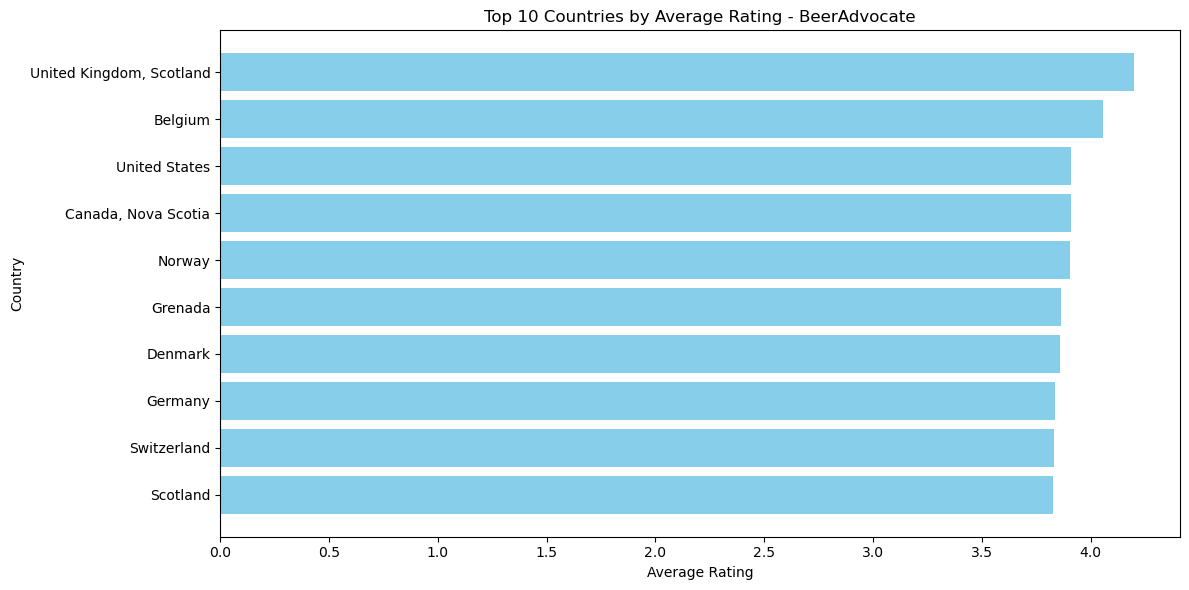

In [120]:
# Plot Top 10 Countries by Average Rating - BeerAdvocate
plt.figure(figsize=(12, 6))
plt.barh(ba_top_10['brewery_location'], ba_top_10['average_rating'], color='skyblue')
plt.title("Top 10 Countries by Average Rating - BeerAdvocate")
plt.xlabel("Average Rating")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

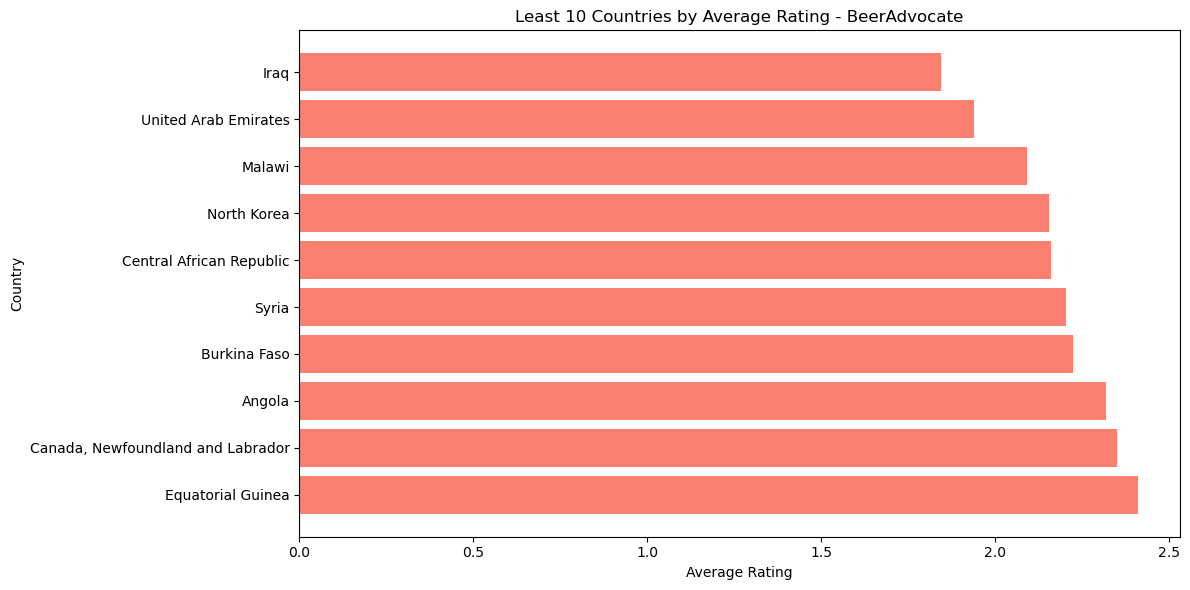

In [121]:
# Plot Least 10 Countries by Average Rating - BeerAdvocate
plt.figure(figsize=(12, 6))
plt.barh(ba_least_10['brewery_location'], ba_least_10['average_rating'], color='salmon')
plt.title("Least 10 Countries by Average Rating - BeerAdvocate")
plt.xlabel("Average Rating")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

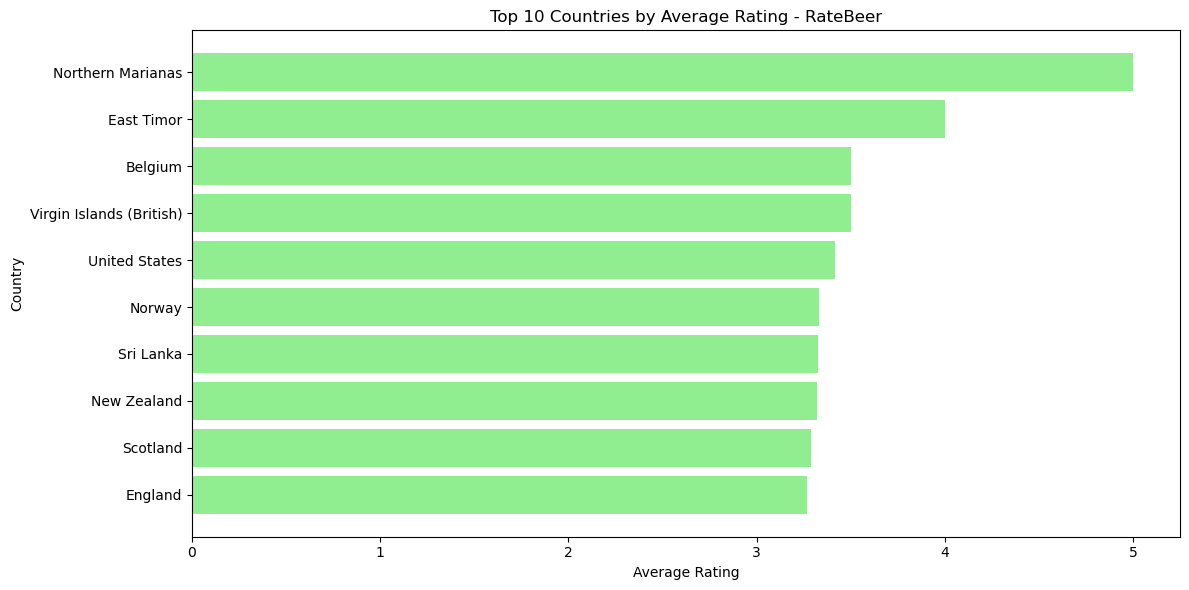

In [122]:
# Plot Top 10 Countries by Average Rating - RateBeer
plt.figure(figsize=(12, 6))
plt.barh(rb_top_10['brewery_location'], rb_top_10['average_rating'], color='lightgreen')
plt.title("Top 10 Countries by Average Rating - RateBeer")
plt.xlabel("Average Rating")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

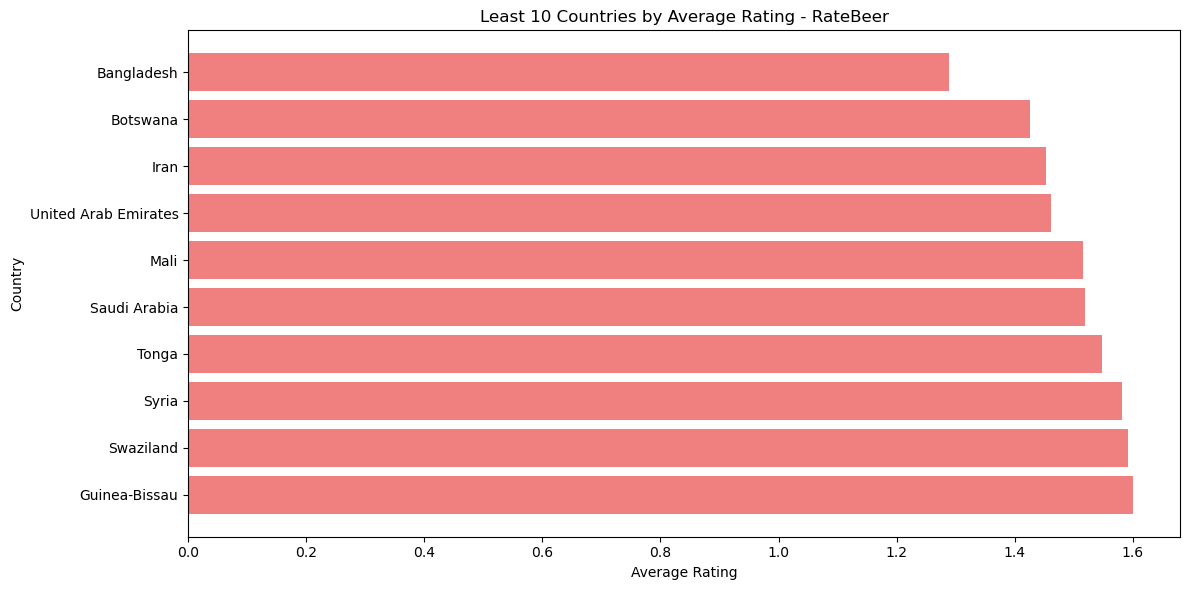

In [123]:
# Plot Least 10 Countries by Average Rating - RateBeer
plt.figure(figsize=(12, 6))
plt.barh(rb_least_10['brewery_location'], rb_least_10['average_rating'], color='lightcoral')
plt.title("Least 10 Countries by Average Rating - RateBeer")
plt.xlabel("Average Rating")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

On BeerAdvocate, countries like Scotland, Belgium, and the United States rank among the top 10, with high average ratings. We conclude that the trend aligns with these countries' rich brewing traditions and strong cultural associations with beer, and it possibly leads to more favorable reviews. We observed similar patterns on RateBeer, with high ratings for Belgium and the United States, also with additional entries like the Northern Marianas and East Timor. Some regions in the top 10 (such as Virgin Islands and Norway) may not be widely known for their beer culture but might have high ratings due to a small number of highly rated, niche beers that stand out. Countries like Belgium and Germany, who are known for quality beer production, supports the idea that culturally significant beer-producing nations receive high average ratings. 


In contrast, countries in the least 10 average ratings—such as Iraq, United Arab Emirates, and North Korea on BeerAdvocate, and countries like Bangladesh, Botswana, and Iran on RateBeer are often places where alcohol consumption is culturally or legally restricted. This could limit the variety and quality of beers available, and contributes to lower average ratings. The countries with fewer cultural connections to beer brewing suggests that limited beer exposure or lower availability may result in more critical reviews, or that the available beers do not meet the quality expectations of users.

We will use an ANOVA test to check if there are significant differences in the average ratings between different geographic areas. This test is feasible when we compare averages between multiple groups. The ANOVA test will return an F-statistic and a p-value. If the p-value is below a significance level, we can conclude that there are statistically significant differences in the ratings between countries.

In [124]:
# Gather ratings by location for BeerAdvocate
ba_ratings_by_location = [group['rating'].values for _, group in ba_ratings_loc_filtered.groupby('brewery_location')]

# Perform ANOVA test for BeerAdvocate
ba_anova_result = f_oneway(*ba_ratings_by_location)
print("BeerAdvocate ANOVA test result:", ba_anova_result)

# Gather ratings by location for RateBeer
rb_ratings_by_location = [group['rating'].values for _, group in rb_ratings_loc_filtered.groupby('brewery_location')]

# Perform ANOVA test for RateBeer
rb_anova_result = f_oneway(*rb_ratings_by_location)
print("RateBeer ANOVA test result:", rb_anova_result)


BeerAdvocate ANOVA test result: F_onewayResult(statistic=2026.4993121135738, pvalue=0.0)
RateBeer ANOVA test result: F_onewayResult(statistic=3526.440733301745, pvalue=0.0)


The ANOVA test results for BeerAdvocate and RateBeer show that there are significant differences in average beer ratings across countries. Both tests produced very high F-statistics, around 2026.50 for BeerAdvocate and 3526.44 for RateBeer, with p-values of 0. This means it’s extremely unlikely that these results happened by chance, so we can reject the null hypothesis that the average ratings are the same in each country. This suggests that people from different countries rate beers differently, likely due to cultural or regional preferences.

To better understand rating behaviors across different countries, we can analyze the number of ratings and reviews submitted by users from each location. This will help us identify if some regions have more active rating communities than others. If certain countries have significantly higher levels of activity, it could impact the overall ratings on the platform, potentially creating biases that reflect the preferences of the most active user groups. By examining both the total activity and the average ratings and reviews per user in each country, we can get a clearer picture of how regional differences might influence beer ratings.

In [125]:
#for beer advocate

#Calculate total ratings and reviews by country
user_activity_totals = ba_users_loc_filtered.groupby('location')[['nbr_ratings', 'nbr_reviews']].sum().reset_index()
user_activity_totals.columns = ['Country', 'Total Ratings', 'Total Reviews']
user_activity_totals_sorted = user_activity_totals.sort_values(by=['Total Ratings', 'Total Reviews'], ascending=False)

# Display total activity levels by country
print("Total User Activity by Country")
print(user_activity_totals_sorted)

Total User Activity by Country
             Country  Total Ratings  Total Reviews
51     United States        7303870        2241334
6             Canada         274512         126591
12           England          41597          21017
1          Australia          34915          25947
45            Sweden          29914           9067
29       Netherlands          22952           9740
16           Germany          17460           8234
36           Romania          16823           3490
3            Belgium          16478           4053
37            Russia          10521           2218
44             Spain           9585           4108
4             Brazil           8628           1025
38          Scotland           7382           3948
28            Mexico           6500           3816
22           Ireland           6207           1212
25             Japan           6151           2685
15            France           6135           3605
24             Italy           5930           2998


In [126]:
# for ratebeer
user_activity_totals_rb = rb_users_loc_filtered.groupby('location')[['nbr_ratings']].sum().reset_index()
user_activity_totals_rb.columns = ['Country', 'Total Ratings']
user_activity_totals_rb_sorted = user_activity_totals_rb.sort_values(by='Total Ratings', ascending=False)

# Display total activity levels by country for RateBeer
print("Total User Activity by Country (RateBeer)")
print(user_activity_totals_rb_sorted)

Total User Activity by Country (RateBeer)
             Country  Total Ratings
53     United States        3274619
11           Denmark         633814
6             Canada         546493
12           England         465714
47            Sweden         305113
29       Netherlands         263071
16           Germany         238709
32            Norway         231676
34            Poland         207299
14           Finland         205541
3            Belgium         136598
1          Australia         106167
39          Scotland         105693
46             Spain          61230
24             Italy          60541
13           Estonia          58004
15            France          38485
9            Croatia          35313
25             Japan          34699
23            Israel          34581
48       Switzerland          33000
42   Slovak Republic          32383
10    Czech Republic          27678
30       New Zealand          26949
19           Hungary          26665
2            Austria  

In [127]:
#for beer advocate

#Calculate average ratings and reviews per user by country
user_activity_averages = ba_users_loc_filtered.groupby('location')[['nbr_ratings', 'nbr_reviews']].mean().reset_index()
user_activity_averages.columns = ['Country', 'Average Ratings per User', 'Average Reviews per User']
user_activity_averages_sorted = user_activity_averages.sort_values(by=['Average Ratings per User', 'Average Reviews per User'], ascending=False)

# Display average activity levels per user by country
print("\nAverage User Activity per User by Country")
print(user_activity_averages_sorted)


Average User Activity per User by Country
             Country  Average Ratings per User  Average Reviews per User
36           Romania                267.031746                 55.396825
30  Northern Ireland                132.500000                 97.590909
45            Sweden                 97.123377                 29.438312
48          Thailand                 91.555556                 43.666667
2            Austria                 88.148148                 19.333333
29       Netherlands                 84.693727                 35.940959
6             Canada                 82.584838                 38.083935
38          Scotland                 73.820000                 39.480000
3            Belgium                 72.590308                 17.854626
1          Australia                 67.144231                 49.898077
51     United States                 64.508713                 19.795748
46       Switzerland                 64.274194                 23.338710
50      

In [128]:
# for rate beer
user_activity_averages_rb = rb_users_loc_filtered.groupby('location')[['nbr_ratings']].mean().reset_index()
user_activity_averages_rb.columns = ['Country', 'Average Ratings per User']
user_activity_averages_rb_sorted = user_activity_averages_rb.sort_values(by='Average Ratings per User', ascending=False)

print("Average User Activity per User by Country (RateBeer)")
print(user_activity_averages_rb_sorted)

Average User Activity per User by Country (RateBeer)
             Country  Average Ratings per User
11           Denmark                614.756547
14           Finland                454.736726
23            Israel                443.346154
13           Estonia                432.865672
42   Slovak Republic                348.204301
32            Norway                344.755952
47            Sweden                303.897410
25             Japan                294.059322
39          Scotland                279.611111
16           Germany                267.911336
50          Thailand                264.829787
29       Netherlands                240.247489
9            Croatia                227.825806
10    Czech Republic                183.298013
12           England                170.341624
6             Canada                167.893395
48       Switzerland                165.829146
18         Hong Kong                145.531250
3            Belgium                133.006816
2      

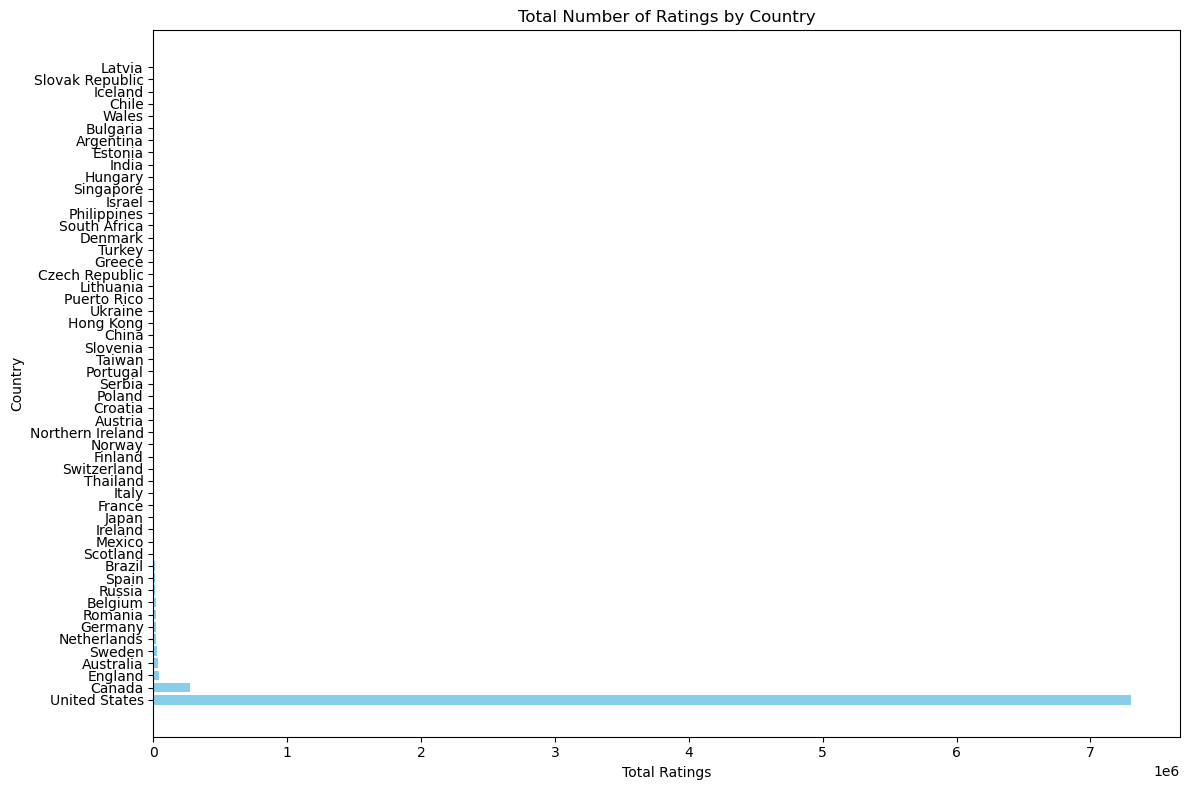

In [129]:
# Plot Total Ratings by Country 
user_activity_totals_sorted = user_activity_totals.sort_values(by='Total Ratings', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(user_activity_totals_sorted['Country'], user_activity_totals_sorted['Total Ratings'], color='skyblue')
plt.title("Total Number of Ratings by Country")
plt.xlabel("Total Ratings")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


As we have a large disparity in the values, US has a lot of ratings and this does not give us a good display of the data. Therefore, we will use a logarithmic scale . In this way, we can compare countries with few ratings to countries with very high ratings.  

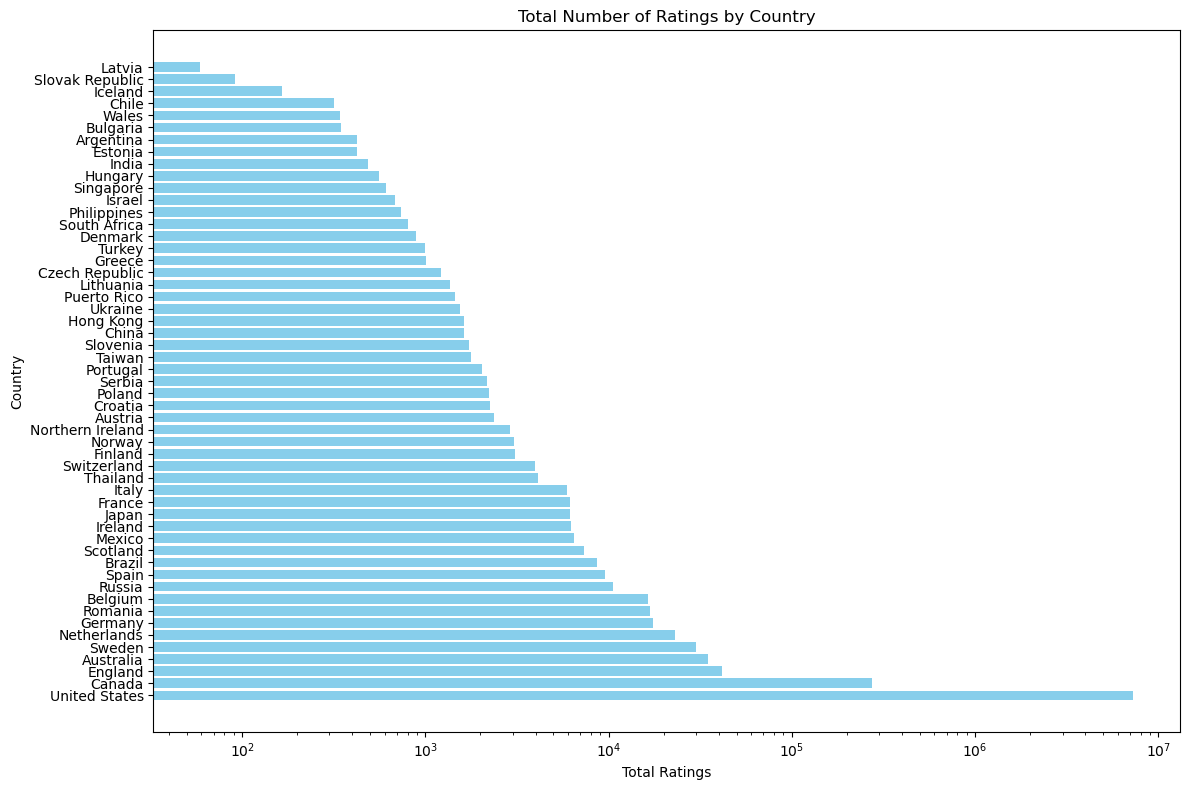

In [130]:
user_activity_totals_sorted = user_activity_totals.sort_values(by='Total Ratings', ascending=False)
# Plot Total Ratings by Country with sorted values and a logarithmic scale
plt.figure(figsize=(12, 8))
plt.barh(user_activity_totals_sorted['Country'], user_activity_totals_sorted['Total Ratings'], color='skyblue')
plt.title("Total Number of Ratings by Country")
plt.xlabel("Total Ratings")
plt.ylabel("Country")
plt.xscale('log')
plt.tight_layout()
plt.show()


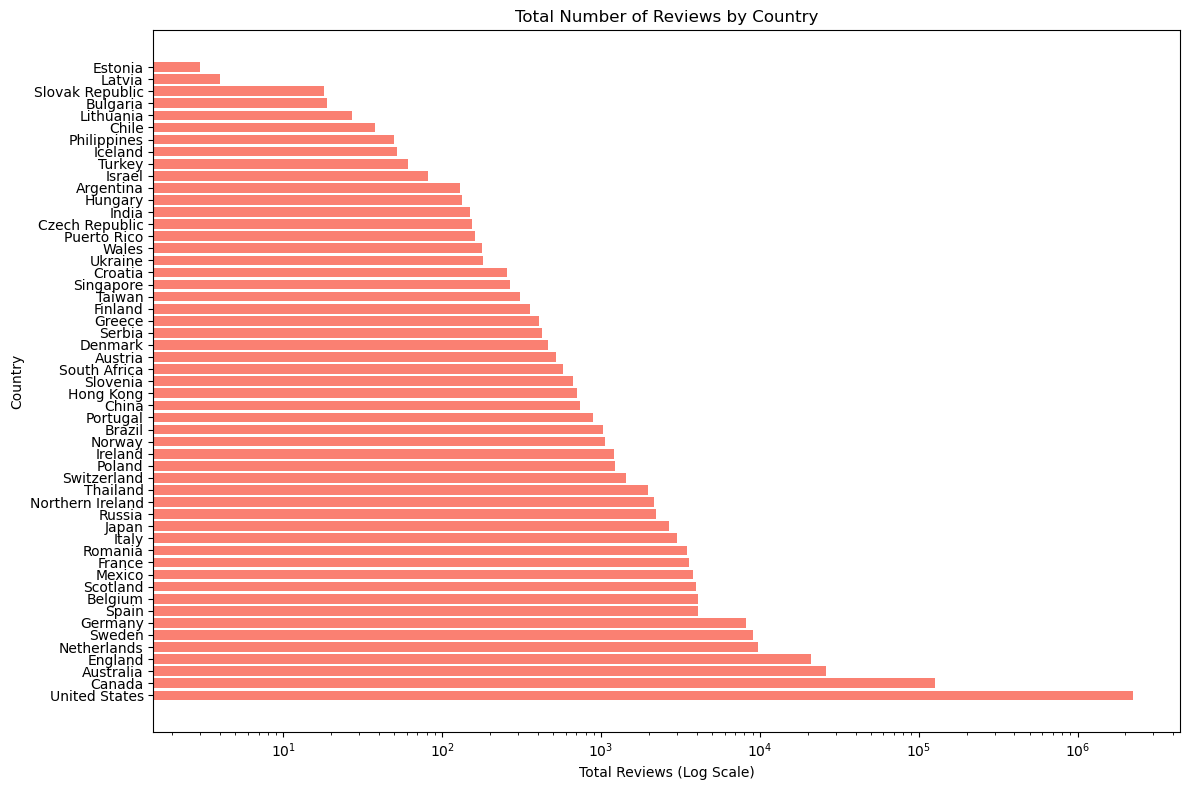

In [131]:
# Sort user_activity_totals by 'Total Reviews' in descending order
user_activity_totals_sorted = user_activity_totals.sort_values(by='Total Reviews', ascending=False)

# Plot Total Reviews by Country with a logarithmic scale
plt.figure(figsize=(12, 8))
plt.barh(user_activity_totals_sorted['Country'], user_activity_totals_sorted['Total Reviews'], color='salmon')
plt.title("Total Number of Reviews by Country")
plt.xlabel("Total Reviews (Log Scale)")
plt.ylabel("Country")
plt.xscale('log')
plt.tight_layout()
plt.show()

The analysis of rating behaviors across different countries suggests that certain regions have much higher levels of activity on the platform. Countries like the United States and Canada, also some European nations, contribute the majority of ratings and reviews. This high activity means that these countries’ preferences are more likely to dominate the overall ratings, and we could most possible have a cultural bias. For instance, if users in the United States tend to favor specific types of beers, those beers might receive higher average ratings on the platform, while beers that are popular in less active regions could be undervalued. The high volume of reviews from these active countries might not fully represent global preferences, which can impact how users perceive the ratings.


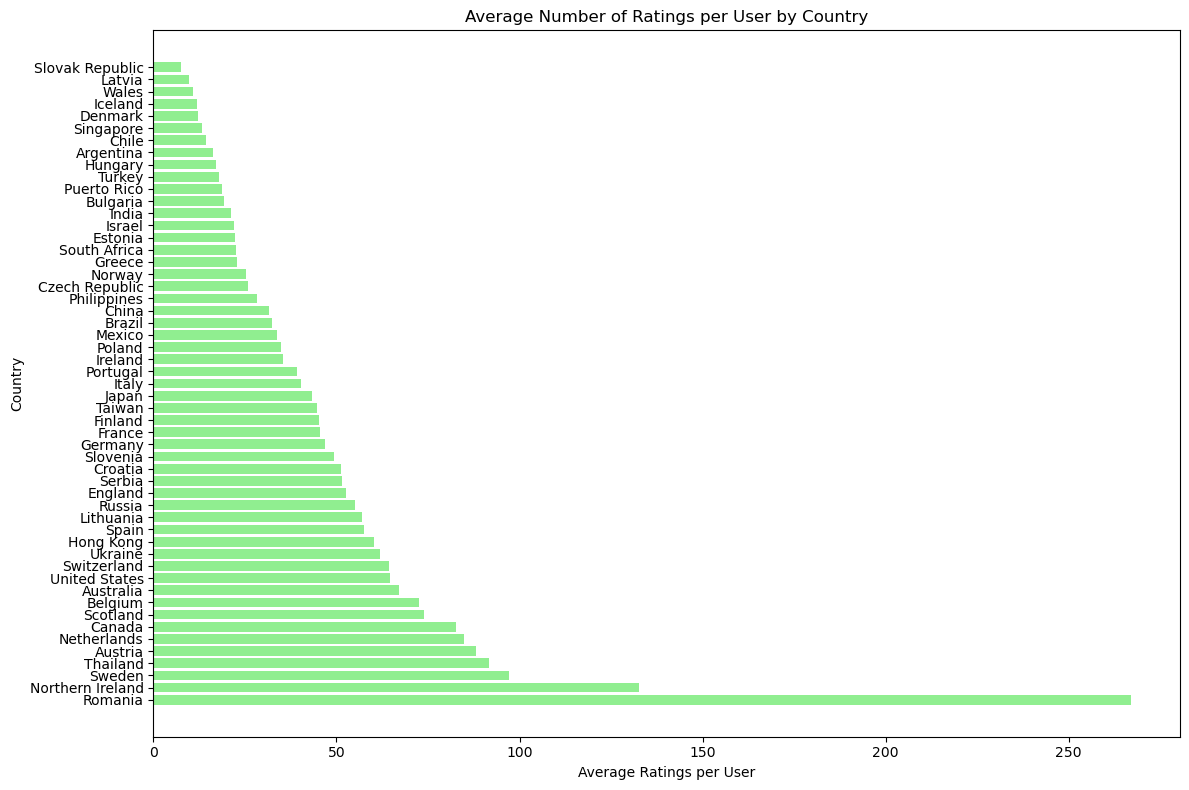

In [132]:
# Average Ratings per User by Country
user_activity_averages_sorted = user_activity_averages.sort_values(by='Average Ratings per User', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(user_activity_averages_sorted['Country'], user_activity_averages_sorted['Average Ratings per User'], color='lightgreen')
plt.title("Average Number of Ratings per User by Country")
plt.xlabel("Average Ratings per User")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

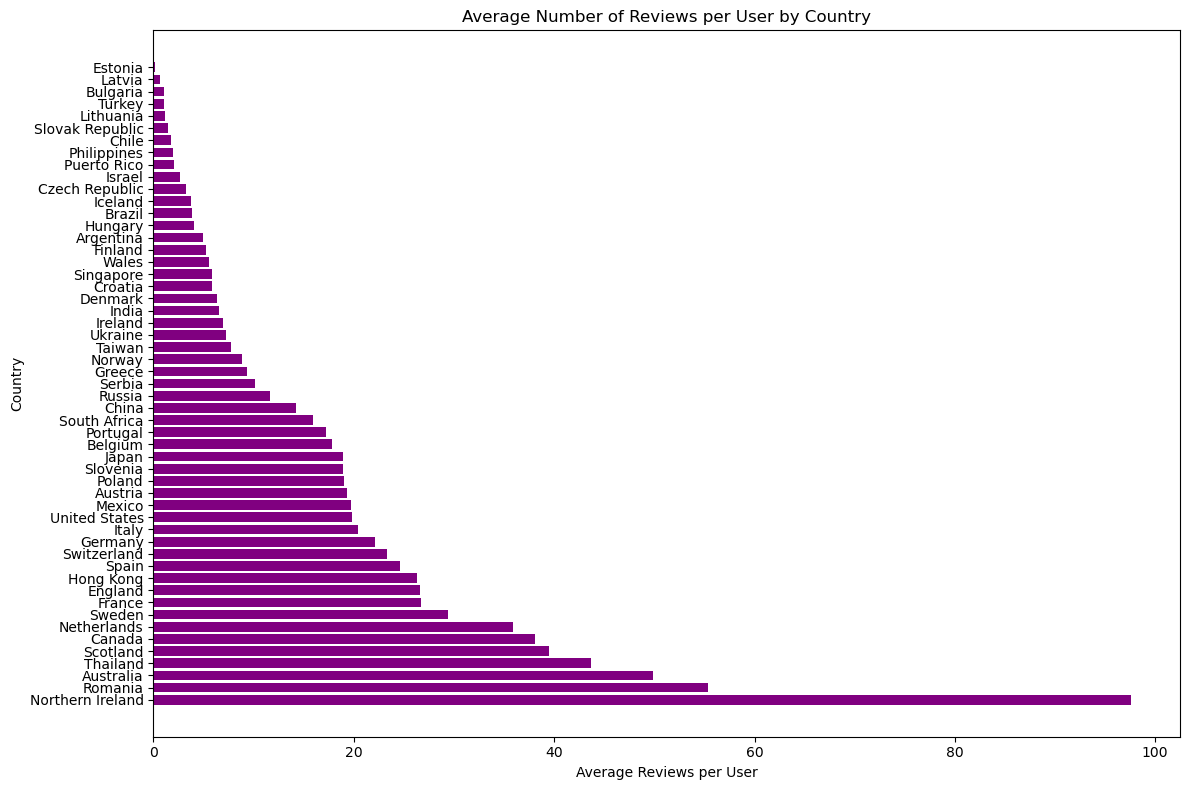

In [133]:
# Average Reviews per User by Country
user_activity_averages_sorted = user_activity_averages.sort_values(by='Average Reviews per User', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(user_activity_averages_sorted['Country'], user_activity_averages_sorted['Average Reviews per User'], color='purple')
plt.title("Average Number of Reviews per User by Country")
plt.xlabel("Average Reviews per User")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

We observed that some countries have higher average ratings and reviews per user. This means that users from certain regions are more active overall and also more engaged individually, they often contribute more reviews per person. We state that this engagement increases the influence of these countries on the platform’s ratings.  For example, users from Northern Ireland or Romania, who show high average reviews per user, prefer strong, dark beers, their frequent reviews could increase the ratings of these beer styles. As a result, the overall beer ratings may reflect the tastes and biases of the most active user groups rather than providing a balanced view of global preferences.

## b) Beer origin bias

In [171]:
# compare the final rating of domestic vs foreign beers and determine if there is a significant difference using statistical tests

# IMPORTANT NOTE: for the following task, do the following:
# 1) for each rating dataframe, perform a value_count on the 'user_location' column: the values correspond to countries that we considered to have enough reviewers
# 2) create a copy of the beer dataframes to remove beers whose brewerie is not in one of the countries identified above
# task in question: determine if the final rating of a given beer is correlated with the number of reviewers from the country where the beer comes from who reviewed that beer (scatter plot + Pearson’s correlation coefficient + regression)

# isolate beer enthusiasts (who wrote a very large number of reviews) and compare the final rating of domestic vs foreign beers and determine if there is a significant difference using statistical tests

# 3) Other biases

## a) Seasonal biases

In [172]:
# use the time information to determine the season during which each rating was posted (only consider countries with 4 seasons)
# group ratings by season
# within each group, determine the average final rating of each beer style
# compare the results for the different seasons

This function categorizes each month into a season to identify when each beer rating was posted. We’re only considering countries with four seasons.

In [52]:
# determine season based on date
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

Here, we apply the get_season function to add a 'season' column to both ba_ratings_ (BeerAdvocate) and rb_ratings_ (RateBeer) datasets, ensuring each rating has its respective season assigned.

In [53]:
# Add season information to ratings dataframes
ba_ratings['season'] = ba_ratings['date'].apply(lambda x: get_season(pd.to_datetime(x)))
rb_ratings['season'] = rb_ratings['date'].apply(lambda x: get_season(pd.to_datetime(x)))

This code block generates boxplots showing the distribution of ratings by season for each platform, providing a visual sense of seasonal variation in ratings.

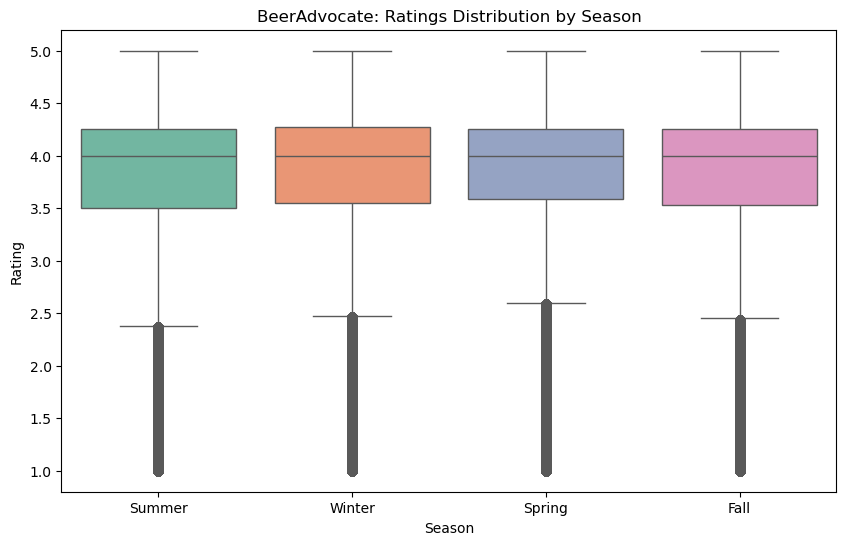

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='rating', data=ba_ratings, palette="Set2")
plt.title("BeerAdvocate: Ratings Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Rating")
plt.show()
plt.close()

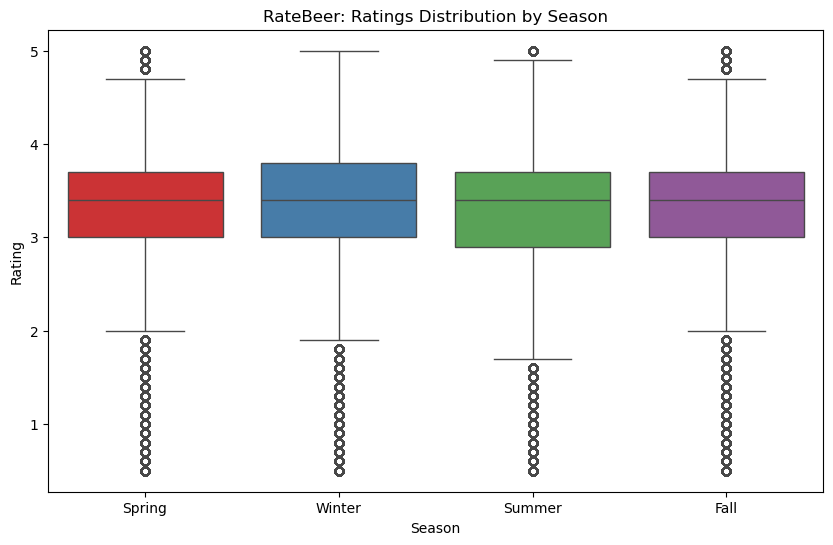

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='rating', data=rb_ratings, palette="Set1")
plt.title("RateBeer: Ratings Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Rating")
plt.show()
plt.close()

This part calculates the average rating for each season on both platforms and then combines these into a single DataFrame for easier comparison

In [56]:
# Group by season, then calculate average final rating within each season
ba_seasonal_avg = ba_ratings.groupby('season')['rating'].mean().reset_index()
rb_seasonal_avg = rb_ratings.groupby('season')['rating'].mean().reset_index()

In [57]:
# Combine BeerAdvocate and RateBeer seasonal averages
seasonal_avg = pd.concat([ba_seasonal_avg, rb_seasonal_avg], keys=['BeerAdvocate', 'RateBeer']).reset_index(level=0).rename(columns={'level_0': 'source'})
seasonal_avg = seasonal_avg.groupby(['season', 'source'])['rating'].mean().unstack()

In [58]:
print("Seasonal Bias Analysis - Average Ratings per Style by Season")
display(seasonal_avg)

Seasonal Bias Analysis - Average Ratings per Style by Season


source,BeerAdvocate,RateBeer
season,,
Fall,3.881269,3.277560
Spring,3.895683,3.301566
Summer,3.858463,3.262542
Winter,3.893652,3.301215


Both BeerAdvocate and RateBeer show slight variations in ratings across seasons. Average ratings on BeerAdvocate are relatively stable, with minor variations, while RateBeer ratings show a bit more fluctuation across seasons. Winter and Spring generally have slightly higher ratings than Summer and Fall, possibly due to seasonal preferences for richer or stronger beers that are typically enjoyed in cooler weather.

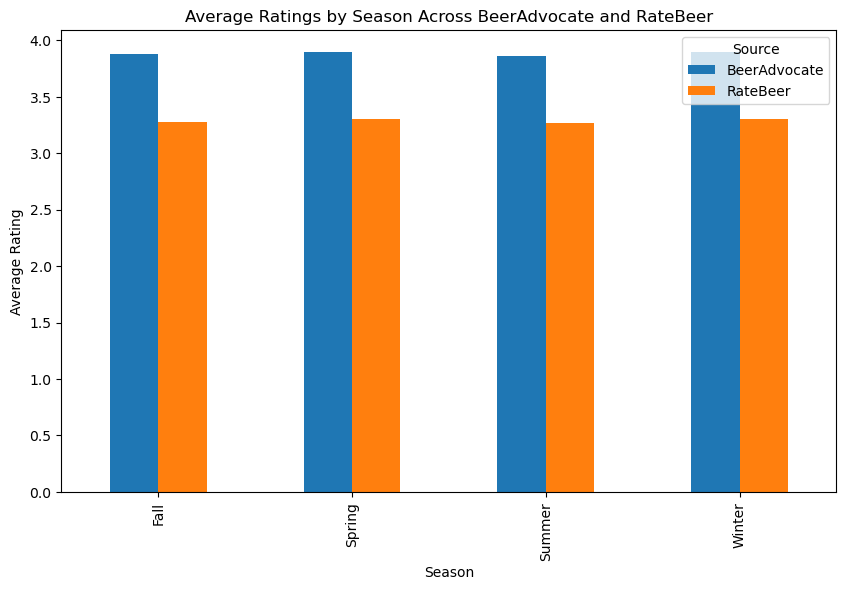

In [59]:
# Plot average ratings across seasons
seasonal_avg.plot(kind='bar', figsize=(10, 6))
plt.title("Average Ratings by Season Across BeerAdvocate and RateBeer")
plt.xlabel("Season")
plt.ylabel("Average Rating")
plt.legend(title='Source')
plt.show()
plt.close()

BeerAdvocate ratings tend to be consistently higher than those on RateBeer across all seasons, which might reflect differences in user base preferences or rating scales.

In [60]:
# Correlation matrix for seasonal ratings between BeerAdvocate and RateBeer
correlation_matrix = seasonal_avg.corr()
print("Correlation Matrix of Seasonal Ratings between BeerAdvocate and RateBeer")
display(correlation_matrix)

Correlation Matrix of Seasonal Ratings between BeerAdvocate and RateBeer


source,BeerAdvocate,RateBeer
source,,
BeerAdvocate,1.000000,0.968152
RateBeer,0.968152,1.000000


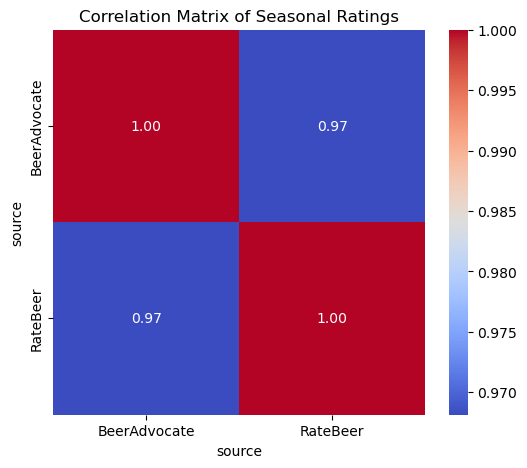

In [61]:
# Heatmap of correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Seasonal Ratings")
plt.show()
plt.close()

The high correlation (0.97) between BeerAdvocate and RateBeer seasonal ratings indicates that both platforms exhibit similar seasonal patterns, despite variations in their absolute values. This strong correlation suggests a shared trend in beer preferences among users, regardless of platform differences.

## b) Experience biais

To analyze how users’ rating tendencies evolve with experience, we will focus on users who have posted a substantial number of reviews, based on a chosen threshold. Let us set that threshold arbitrarily to 15 reviews, which seems like a number of reviews that is high enough to be able to define different experience levels.

First, let us verify that we have enough users who wrote at least this many reviews.

In [184]:
REVIEW_NB_THRESHOLD = 15

# calculate the counts of each 'user_id' in the review dataframes
ba_user_counts = ba_ratings['user_id'].value_counts()
rb_user_counts = rb_ratings['user_id'].value_counts()

# keep only user_id values that appear at least 15 times
ba_prolific_users = ba_user_counts[ba_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()
rb_prolific_users = rb_user_counts[rb_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()

print("Number of users who wrote at least",REVIEW_NB_THRESHOLD,"reviews:")
print('Beer Advocate:',len(ba_prolific_users))
print('Rate Beer:',len(rb_prolific_users))

Number of users who wrote at least 15 reviews:
Beer Advocate: 39945
Rate Beer: 13832


We have about 40 and 14 thousand users who wrote at least 15 reviews on Beer Advocate and Rate Beer, respectively, which seems to be enough data to do perform our analysis. We can also note that we have significantly more data from Beer Advocate than from Rate Beer.
Let us now isolate reviews from these users.

In [185]:
# filter rating dataframes to isolate users who wrote at least 15 reviews
prolific_ba_users_ratings = ba_ratings[ba_ratings.user_id.isin(ba_prolific_users)]
prolific_rb_users_ratings = rb_ratings[rb_ratings.user_id.isin(rb_prolific_users)]

Our analysis will start by sorting the reviews of each user chronologically and assigning an "experience level" to each rating based on the number of reviews they had posted up to that point. These levels will be predefined and consistent across all users: new reviewer (first n reviews), amateur (from the n+1th to the oth review), and expert (from the o+1th review onward).

Let us define these experience levels arbitrarily: we will consider that a user is a new reviewer for the first 5 reviews, an amateur for the 6th to the 10th review and and expert starting from the 11th review. 

In [186]:
# define experience levels
NEW_REVIEWER_THRESHOLD = 5
AMATEUR_THRESHOLD = 10

Let us now add experience levels to the reviews of users who wrote at least 15 reviews

In [187]:
ba_ratings_with_experience_levels = assign_experience_level(prolific_ba_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
ba_ratings_with_experience_levels.sample(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,experience_level
4498937,Moving Parts The Ever Evolving IPA: Batch No. 2,134978.0,Victory Brewing Company - Downingtown,345.0,English India Pale Ale (IPA),6.4,2014-12-24 11:00:00,Drbarriga,drbarriga.912089,4.25,5.00,4.25,4.50,4.25,4.53,new_reviewer
531912,Beer Geek Breakfast,28877.0,Mikkeller ApS,13307.0,Oatmeal Stout,7.5,2017-06-16 10:00:00,fscottkey,fscottkey.776811,5.00,3.75,4.25,3.50,3.75,3.78,expert
7993485,Houblon Chouffe Dobbelen IPA Tripel,27804.0,Brasserie d'Achouffe,321.0,Belgian IPA,9.0,2016-04-02 10:00:00,Dhyan,dhyan.853829,4.25,4.50,4.25,4.25,4.25,4.31,expert
633250,Erdinger Weissbier Dunkel,2041.0,Erdinger Weissbräu,703.0,Dunkelweizen,5.3,2006-04-01 10:00:00,akorsak,akorsak.2845,3.50,3.00,4.00,3.50,4.00,3.53,expert
3585555,Original Honey Brown Extra Rich Lager (Beer Br...,832.0,Genesee Brewing Co. / Dundee Brewing Co.,302.0,American Amber / Red Lager,4.5,2012-12-09 11:00:00,stoney1031,stoney1031.705858,NaN,NaN,NaN,NaN,NaN,3.00,expert


In [188]:
rb_ratings_with_experience_levels = assign_experience_level(prolific_rb_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
rb_ratings_with_experience_levels.sample(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,experience_level
1246889,Karlsberg Bock,42461.0,Karlsberg Brauerei,688.0,Dunkler Bock,6.5,2014-01-21 11:00:00,McTapps,207907.0,4.0,6.0,4.0,8.0,12.0,3.4,expert
508678,Birra del Borgo ReAle,49598.0,Birra del Borgo (AB InBev),6100.0,American Pale Ale,6.4,2015-12-21 11:00:00,AnG_BrgNor,391076.0,3.0,6.0,3.0,6.0,12.0,3.0,expert
2190242,Nynäshamns Sotholmen Extra Stout,26977.0,Nynäshamns Ångbryggeri,1067.0,Foreign Stout,6.6,2007-02-18 11:00:00,lagomswedish,44442.0,5.0,8.0,4.0,7.0,17.0,4.1,expert
2090779,Vakka-Suomen Prykmestar Oktoberfestbier,156854.0,Vakka-Suomen Panimo,9634.0,Oktoberfest/Märzen,5.7,2011-10-20 10:00:00,lusikka,85448.0,3.0,5.0,2.0,5.0,10.0,2.5,expert
5660227,Inveralmond Blackfriar Scottish Ale,28969.0,Inveralmond,208.0,Scotch Ale,7.0,2011-10-15 10:00:00,ration,134159.0,4.0,7.0,3.0,6.0,14.0,3.4,expert


We will now calculate the average final rating (denoted as 'rating' in the ratings DataFrames) for each experience level across all users.

In [189]:
experience_order = ['new_reviewer', 'amateur', 'expert']

# average final rating for each experience level for BeerAdvocate data
ba_final_rating_by_experience_level = ba_ratings_with_experience_levels.groupby('experience_level')['rating'].mean().reindex(experience_order)
print('BeerAdvocate:\n',ba_final_rating_by_experience_level)

# average final rating for each experience level for RateBeer data
rb_final_rating_by_experience_level = rb_ratings_with_experience_levels.groupby('experience_level')['rating'].mean().reindex(experience_order)
print('RateBeer:\n',rb_final_rating_by_experience_level)

BeerAdvocate:
 experience_level
new_reviewer    3.961161
amateur         3.925924
expert          3.870697
Name: rating, dtype: float64
RateBeer:
 experience_level
new_reviewer    3.289357
amateur         3.296209
expert          3.279761
Name: rating, dtype: float64


Let us visualize the results with a bar chart.

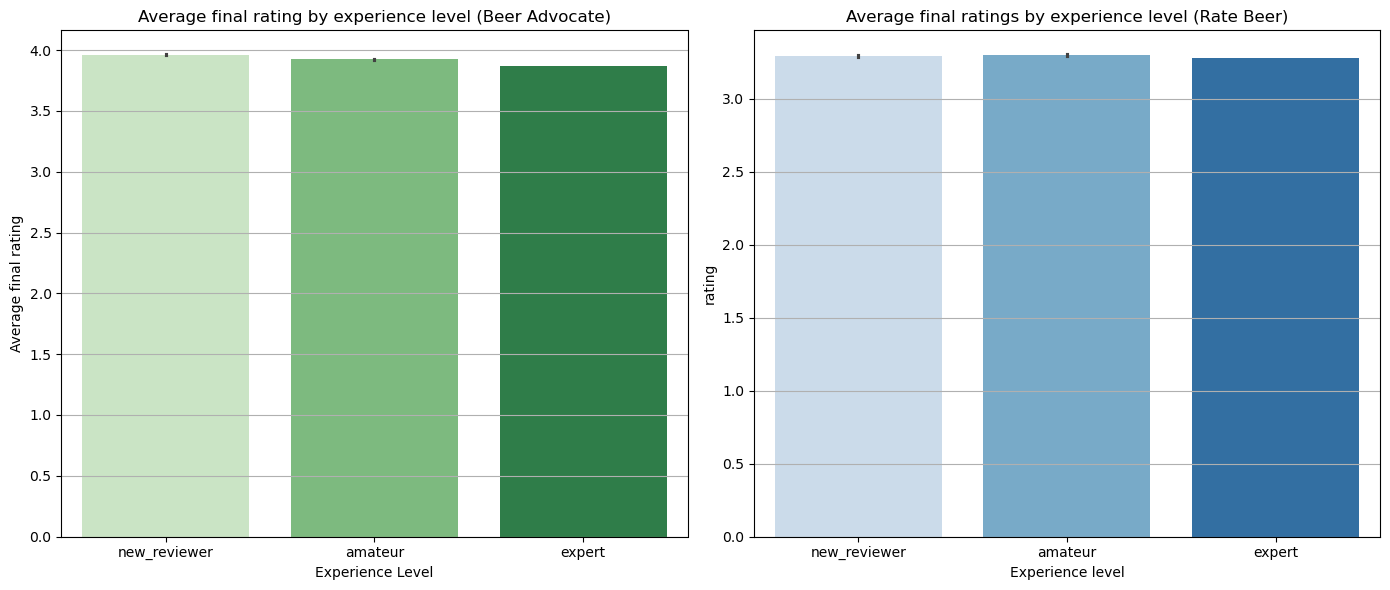

In [190]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='experience_level', y='rating', data=ba_ratings_with_experience_levels, order=['new_reviewer', 'amateur', 'expert'], ci=95, palette='Greens')
plt.title('Average final rating by experience level (Beer Advocate)')
plt.xlabel('Experience Level')
plt.ylabel('Average final rating')
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
sns.barplot(x='experience_level', y='rating', data=rb_ratings_with_experience_levels, order=['new_reviewer', 'amateur', 'expert'], ci=95, palette='Blues')
plt.title('Average final ratings by experience level (Rate Beer)')
plt.xlabel('Experience level')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()
plt.close()

For both Beer Advocate and Beer Review data, we can see that the average final rating given by "expert" users is slightly smaller than that given by "new reviewers". While the difference is small, the confidence itervals do not overlap, suggesting that the differences, despite being small, may be significant.

Let us investigate this phenomenon further by examining how final ratings evolve with experience when considering users separately. To do so, we will test whether the average rating of reviews labeled as 'new_reviewer' is greater than the average rating of reviews labeled as 'expert' for a given user, using a one-tailed t-test.

In [191]:
# Beer Advocate
# group the data by 'user_id' and 'experience_level' to calculate the average rating for each experience level and for each user
ba_average_final_rating_by_user_and_experience_level = ba_ratings_with_experience_levels.groupby(['user_id', 'experience_level'])['rating'].mean().unstack()

# perform a one-tailed t-test
t_stat, p_value = ttest_rel(ba_average_final_rating_by_user_and_experience_level['new_reviewer'], ba_average_final_rating_by_user_and_experience_level['expert'])

if t_stat > 0:  # case where 'new reviewer' average rating is greater than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")

else: # case where 'new reviewer' average rating is smaller than 'expert' average rating
    print('No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.')

T-statistic: 11.546972007985525, One-tailed P-value: 4.279385395467664e-31


In [192]:
# Rate Beer
# group the data by 'user_id' and 'experience_level' to calculate the average rating for each experience level and for each user
rb_average_final_rating_by_user_and_experience_level = rb_ratings_with_experience_levels.groupby(['user_id', 'experience_level'])['rating'].mean().unstack()

# perform a one-tailed t-test
t_stat, p_value = ttest_rel(rb_average_final_rating_by_user_and_experience_level['new_reviewer'], rb_average_final_rating_by_user_and_experience_level['expert'])

if t_stat > 0:  # case where 'new reviewer' average rating is greater than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")
    
else: # case where 'new reviewer' average rating is smaller than 'expert' average rating
    print('No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.')

No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.


Given the output for the Rate Beer data, let us instead test whether the average rating of reviews labeled as 'new_reviewer' is lower than the average rating of reviews labeled as 'expert' for a given user.

In [193]:
# perform a one-tailed t-test
t_stat, p_value = ttest_rel(rb_average_final_rating_by_user_and_experience_level['expert'], rb_average_final_rating_by_user_and_experience_level['new_reviewer'])

if t_stat > 0:  # case where 'new reviewer' average rating is lower than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")
    
else: # case where 'new reviewer' average rating is larger than 'expert' average rating
    print('No support found for the alternative hypothesis that expert ratings are greater than new_reviewer ratings.')

T-statistic: 13.625526413709126, One-tailed P-value: 2.635403140036256e-42


The one-tailed t-test testing whether the average rating of reviews labeled as 'new_reviewer' is greater than the average rating of reviews labeled as 'expert' for a given user performed on the Beer Advocate data yielded a positive test statistic, which suggests that the mean of new reviewer ratings is higher than the mean of expert ratings. The p-value is extremely small (p_value << 0.05), which means that the mean of the new_reviewer ratings is significantly higher than the mean of the expert ratings.

In contrast, the one-tailed t-test testing whether the average rating of reviews labeled as 'new_reviewer' is lower than the average rating of reviews labeled as 'expert' for a given user performed on the Rate Beer data yielded a positive test statistic, which suggests that the mean of new reviewer ratings is lower than the mean of expert ratings. The p-value is extremely small (p_value << 0.05), which means that the mean of the new_reviewer ratings is significantly lower than the mean of the expert ratings.

While these results appear contradictory, it is important to note that they were calculated on data from 40,000 users in Beer Advocate versus 14,000 users in Rate Beer. The larger sample size in Beer Advocate may make the corresponding results more representative of user behavior. However, these differences could also reflect distinct user rating cultures (especially since the ditribution of origins of reviewers from the 2 platforms differ significantly) or rating scales between the platforms. Thus, while we cannot conclude with certainty that users become more critical with experience across all platforms, the Beer Advocate data might suggest a trend in this direction. Further analysis with more data from both platforms or additional datasets could clarify if these patterns are platform-specific or represent a broader trend.